# **Imputing Daily Gas Prices**

This project explores how we can impute daily gas prices using weekly gas prices. This can be effient for forecasting, reducing the amount of data that needs to be stored, and reducing the amount of data that needs to be processed.

## SETUP

I'll start by importing the libraries I need. Then importing and storing it in a pandas DataFrame called `df`.

In [1]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statistics import variance as var # Used for calculating variance
from sklearn.linear_model import LinearRegression # Used for linear regression

In [36]:
# Loading the data into a pandas dataframe
df = pd.read_csv('gas_price_data.txt', delimiter='\t', header = 2) # Skipping the first two rows which are just text

 Before I begin any approximation, I'll make sure my data is tidy. To format the dates correctly, I'll use the `pd.to_datetime` function. 
 
 My goal here is to make the dataframe structure that I expect as my output, to then only replace the missing values with estimates, and not worry about anything else. So I'll have the dataframe add in daily values using the `resample` function, of course they will have NaN values, which is actually ideal for my purposes. 
 
 Then, I'll add the extra week to the dataset, by first defining its range with `pd.date_range`, making it into a DataFrame, and then appending it to the original DataFrame with `pd.concat`.

In [3]:
# Converting the date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Resampling DataFrame to have one row per day, filling missing dates with NaN
df = df.set_index('Date').resample('D').asfreq().reset_index()

# Creating a range for the extra week starting from the last date in the DataFrame
extra_week_range = pd.date_range(start = df['Date'].max(), periods = 8, freq='D') [1:] 

# Creating a DataFrame for the extra week of dates using the range
extra_week_data = pd.DataFrame({'Date': extra_week_range})

# Concatenating the original DataFrame with the extra week of dates
df = pd.concat([df, extra_week_data], ignore_index = True)

/var/folders/4z/1s07dvg55sq1ks6sghlxv2rh0000gn/T/ipykernel_64831/2991573331.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


In [4]:
# Saving the DataFrame to csv to view the data
df.to_csv('df.csv')

## LINEAR APPROXIMATION

My approach for linear approximation is to first make a copy of the original DataFrame, to make sure I'm estimating points using original data, and not other estimates. My main methodology is iterating through the column the function estimates, until I reach a NaN value, at which point the function will mark the point before it (which is logically never NaN as our dataset starts with a non-NaN value) and the point after it, which is found using further iteration. For the extra week into future however, we don't have a next point, so I'll use the two previous points to estimate the values instead. 

From here on, I write conditions to differentiate between the last week's approach and the rest of the dataset, and assign my $x$ and $y$ values accordingly. Then I'll calculate the slope and then plugging the values into the equation of a line to get the estimated value. Here, $y$ is the the NaN value, being replaced (estimated).

After the loop is done iterating through the length of the DataFrame, we can be sure, that all NaN values have been replaced with their estimates. So, the function will go on to return the, now complete, column. So the function has to be run once for the `Diesel` column, and once for the `Regular` column.

I'll also visualize the data with a scatter plot to see how well the approximation worked using the `matplotlib` library. Note that the variance is calculated using the `variance` function from the `statistics` library.

In [5]:
# Defining a function to linearly approximate the missing values and return a numpy array
def linearApproximate(column: np.ndarray) -> np.ndarray:
    weekly_prices = column.copy() # Storing the column's original values
    length = len(column) # Length of the column we are estimating

    # Looping through the column
    for i in range(1, length):
        # Stopping at NaN values, to estimate them
        if pd.isna(column[i]):
            # Marking previous index (which is never NaN)
            prevIndex = i - 1

            # Looking for the next non-NaN value
            nextIndex = i + 1
            while nextIndex < length and pd.isna(weekly_prices[nextIndex]):
                nextIndex += 1

            # In the case of the extra week in the future, there is no next point to use, so we use the last two points
            if nextIndex >= length:
                # Finding the second-to-last valid value
                farPrevIndex = prevIndex - 1
                while pd.isna(weekly_prices[farPrevIndex]):
                    farPrevIndex -= 1
                
                # We check once again if the farPrevIndex is valid before using it
                # We also make sure that the previous index is not NaN and actually in our data range
                if farPrevIndex >= 0 and not pd.isna(weekly_prices[prevIndex]):
                    # Setting the coordinates of the known original points
                    y1, y2 = weekly_prices[farPrevIndex], weekly_prices[prevIndex]
                    x1, x2 = farPrevIndex, prevIndex

            # In other cases, we use the next point as it is below the length's index
            elif nextIndex < length:
                # Setting the coordinates of the known original points
                y1, y2 = weekly_prices[prevIndex], weekly_prices[nextIndex]
                x1, x2 = prevIndex, nextIndex
            else:
                # This will never be reached, but its here for safety
                raise ValueError("Invalid state")

            # Calculating the slope
            slope = (y2 - y1) / (x2 - x1)

            # Filling in the missing values in the week
            for j in range(prevIndex + 1, nextIndex):
                # Using the line equation to estimate the missing value
                column[j] = weekly_prices[prevIndex] + (slope * (j - prevIndex))
                ## print(f"index {j} estimated with {x1}, {x2} and values {y1}, {y2}") # For debugging

    # Returning the updated column
    return column

In [6]:
# Making a copy of the original dataframe to avoid modifying it
GasPrices_Linear = df.copy()
# Estimating the missing values in the Regular and Diesel columns one by one
GasPrices_Linear['Regular'] = linearApproximate(GasPrices_Linear['Regular'].values)
GasPrices_Linear['Diesel'] = linearApproximate(GasPrices_Linear['Diesel'].values)
# Saving the updated dataframe to a CSV file
GasPrices_Linear.to_csv("GasPrices_Linear.csv")

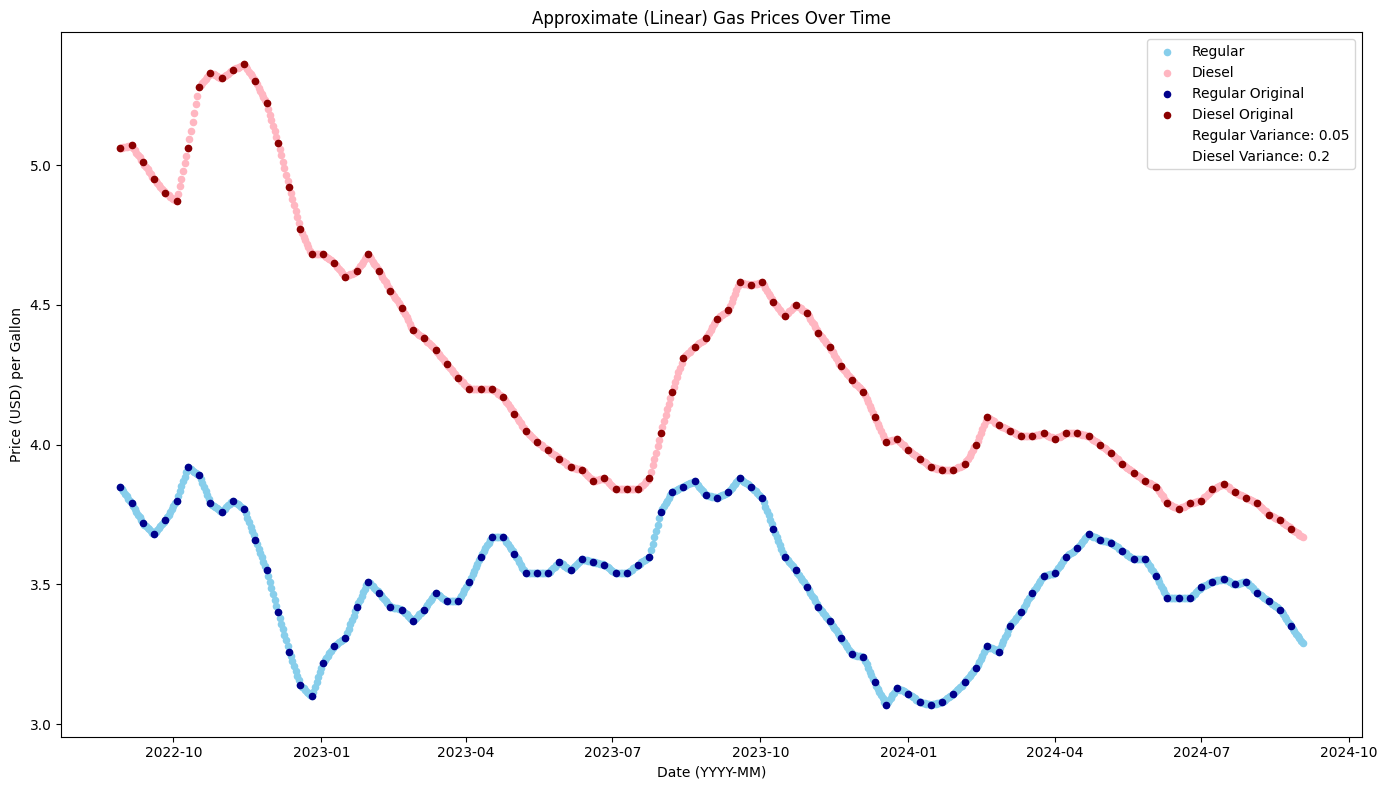

In [7]:
# Figure size
plt.figure(figsize = (14, 8))

# Plotting the approximated values
plt.scatter(GasPrices_Linear['Date'], GasPrices_Linear['Regular'], color='skyblue', s=20, label='Regular')
plt.scatter(GasPrices_Linear['Date'], GasPrices_Linear['Diesel'], color='lightpink', s=20, label='Diesel')

# Plotting the original values
plt.scatter(df['Date'], df['Regular'], color='darkblue', s=20, label='Regular Original')
plt.scatter(df['Date'], df['Diesel'], color='darkred', s=20, label='Diesel Original')

# Calculating Variance
regular_linear_var = f"Regular Variance: {round(var(GasPrices_Linear['Regular']), 2)}"
diesel_linear_var = f"Diesel Variance: {round(var(GasPrices_Linear['Diesel']), 2)}"

# Adding the variance to the legend
plt.plot([], [], ' ', label = regular_linear_var)
plt.plot([], [], ' ', label = diesel_linear_var)

# Labeling
plt.title('Approximate (Linear) Gas Prices Over Time')
plt.xlabel('Date (YYYY-MM)')
plt.ylabel('Price (USD) per Gallon')
plt.legend()

# Displaying
plt.tight_layout()
plt.show()

HISTROGRAM OF THE Y-VALUES (PRICES)

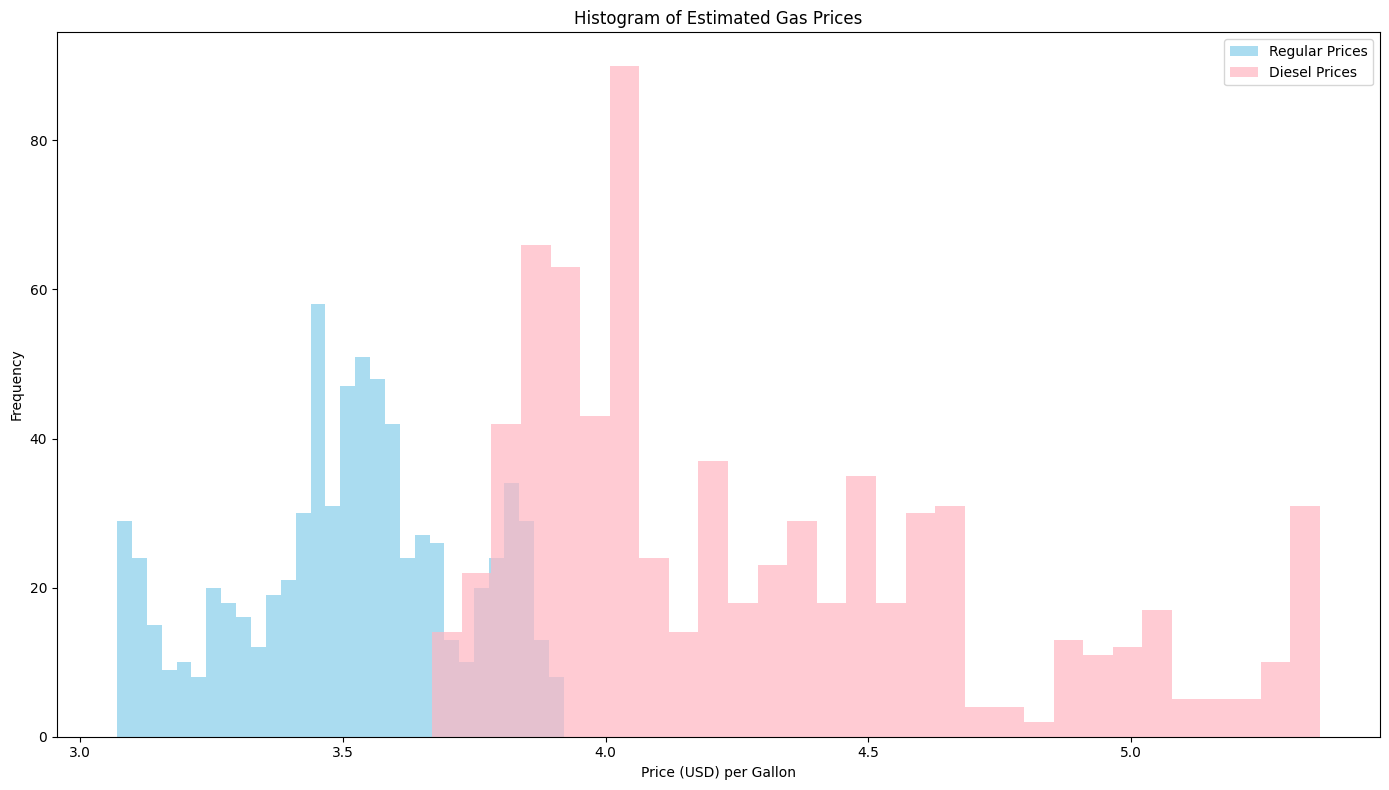

In [8]:
# Figure size
plt.figure(figsize=(14, 8))

# Plotting the histogram of approximated values
plt.hist(GasPrices_Linear['Regular'], bins=30, color='skyblue', alpha=0.7, label='Regular Prices')
plt.hist(GasPrices_Linear['Diesel'], bins=30, color='lightpink', alpha=0.7, label='Diesel Prices')

# Labeling
plt.title('Histogram of Estimated Gas Prices')
plt.xlabel('Price (USD) per Gallon')
plt.ylabel('Frequency')
plt.legend()

# Displaying
plt.tight_layout()
plt.show()

COMPUTED HIGH-BIAS MODEL (LINEAR REGRESSION) FOR THE IMPUTED DATA

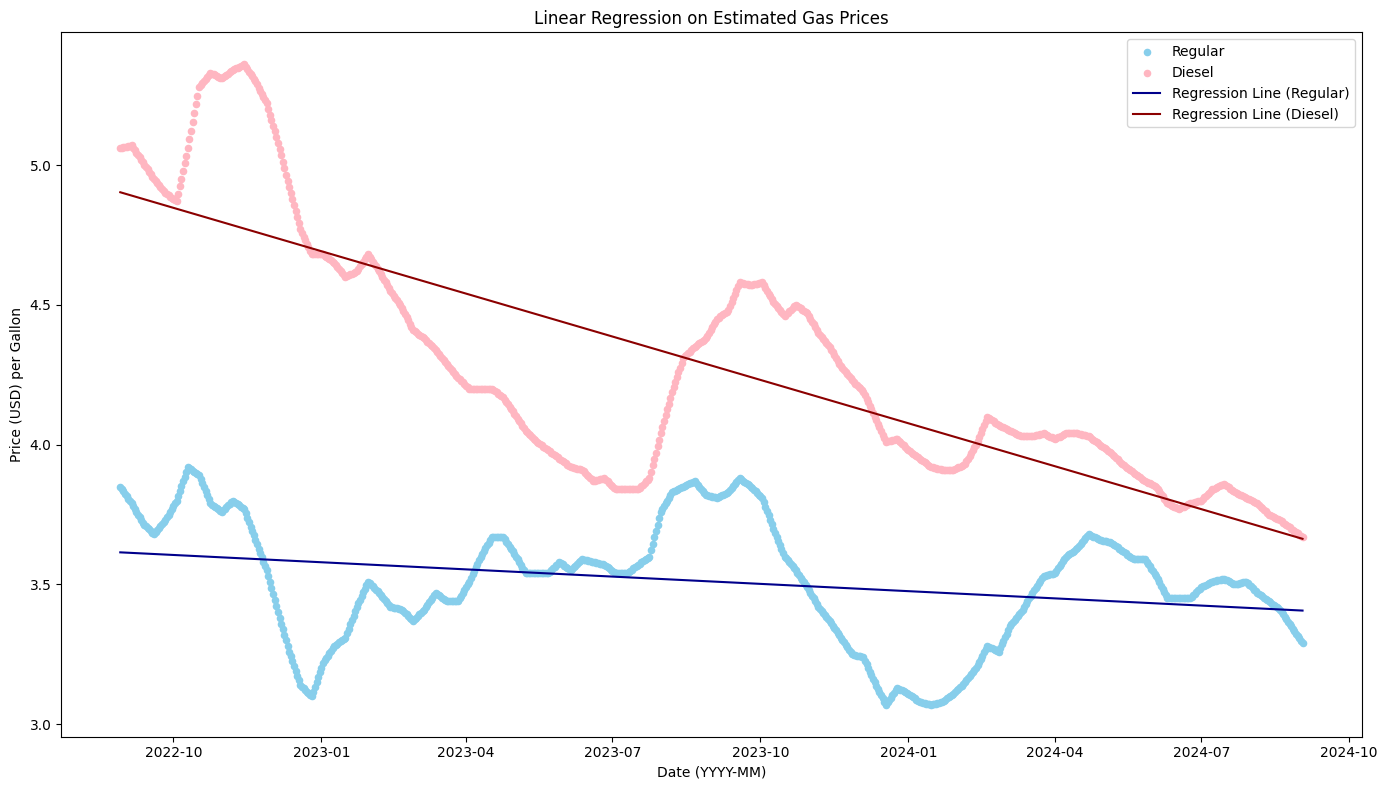

In [9]:
# Creating a sequence from 0 to the length of the DataFrame, and then turning it into a vector with reshape()
x_regular = np.arange(len(GasPrices_Linear)).reshape(-1, 1)
y_regular = GasPrices_Linear['Regular']
x_diesel = np.arange(len(GasPrices_Linear)).reshape(-1, 1) 
y_diesel = GasPrices_Linear['Diesel']

# Fitting the data in the model using the LinearRegression function
regression_regular = LinearRegression()
regression_regular.fit(x_regular, y_regular)
regression_diesel = LinearRegression()
regression_diesel.fit(x_diesel, y_diesel)

# Predicting values using the predict() function
y_predict_regular = regression_regular.predict(x_regular)
y_predict_diesel = regression_diesel.predict(x_diesel)

# Figure size
plt.figure(figsize=(14, 8))

# Plotting the approximated values
plt.scatter(GasPrices_Linear['Date'], GasPrices_Linear['Regular'], color='skyblue', s=20, label='Regular')
plt.scatter(GasPrices_Linear['Date'], GasPrices_Linear['Diesel'], color='lightpink', s=20, label='Diesel')

# Plotting the regression lines
plt.plot(GasPrices_Linear['Date'], y_predict_regular, color='darkblue', label='Regression Line (Regular)')
plt.plot(GasPrices_Linear['Date'], y_predict_diesel, color='darkred', label='Regression Line (Diesel)')

# Labeling
plt.title('Linear Regression on Estimated Gas Prices')
plt.xlabel('Date (YYYY-MM)')
plt.ylabel('Price (USD) per Gallon')
plt.legend()

# Displaying
plt.tight_layout()
plt.show()

## LINEAR APPROXIMATION WITH NOISE

The approach for this is the same as the previous one, with the only difference being that I'll add a random noise to the estimated values. I'll use the `noise = np.random.normal(mean, std, size = column.shape)` code to generate an array of random noise, and then add it to the estimated values. I'm doing the addid within the loop for each value, to make sure that noise is getting added only to the estimated values, and not to the original data.

It is also notable, that the standard deviation of $\sigma = 1.5$, is not suitable for our data, simply because it's too large. I think $\sigma = 0.1$ will work better. So I'll visualize that as well as the initially requested standard deviation.

In [10]:
# Defining a function to linearly approximate the missing values and return a numpy array
# It also takes in the mean and standard deviation of the noise to add to the estimated values
def linearNoisyApproximate(column: np.ndarray, mean, std) -> np.ndarray:
    weekly_prices = column.copy() # Storing the column's original values
    length = len(column) # Length of the column we are estimating

    # Making a noise array to add to the estimated values
    noise = np.random.normal(mean, std, size = column.shape)

    # Looping through the column
    for i in range(1, length):
        # Stopping at NaN values, to estimate them
        if pd.isna(column[i]):
            # Marking previous index (which is never NaN)
            prevIndex = i - 1

            # Looking for the next non-NaN value
            nextIndex = i + 1
            while nextIndex < length and pd.isna(weekly_prices[nextIndex]):
                nextIndex += 1

            # In the case of the extra week in the future, there is no next point to use, so we use the last two points
            if nextIndex >= length:
                # Finding the second-to-last valid value
                farPrevIndex = prevIndex - 1
                while pd.isna(weekly_prices[farPrevIndex]):
                    farPrevIndex -= 1
                
                # We check once again if the farPrevIndex is valid before using it
                # We also make sure that the previous index is not NaN and actually in our data range
                if farPrevIndex >= 0 and not pd.isna(weekly_prices[prevIndex]):
                    # Setting the coordinates of the known original points
                    y1, y2 = weekly_prices[farPrevIndex], weekly_prices[prevIndex]
                    x1, x2 = farPrevIndex, prevIndex

            # In other cases, we use the next point as it is below the length's index
            elif nextIndex < length:
                # Setting the coordinates of the known original points
                y1, y2 = weekly_prices[prevIndex], weekly_prices[nextIndex]
                x1, x2 = prevIndex, nextIndex
            else:
                # This will never be reached, but its here for safety
                raise ValueError("Invalid state")

            # Calculating the slope
            slope = (y2 - y1) / (x2 - x1)

            # Filling in the missing values in the week
            for j in range(prevIndex + 1, nextIndex):
                column[j] = (weekly_prices[prevIndex] + (slope * (j - prevIndex))) + noise[j] # Adding noise to each estimated value

    # Returning the updated column
    return column

In [11]:
# Making a copy of the original dataframe to avoid modifying it
GasPrices_Linear_Noisy = df.copy()
# Declaring the mean and standard deviation of the noise
mean = 0
standard_deviation = 1.5
# Estimating the missing values in the Regular and Diesel columns one by one
GasPrices_Linear_Noisy['Regular'] = linearNoisyApproximate(GasPrices_Linear_Noisy['Regular'].values, mean, standard_deviation)
GasPrices_Linear_Noisy['Diesel'] = linearNoisyApproximate(GasPrices_Linear_Noisy['Diesel'].values, mean, standard_deviation)
# Saving the updated dataframe to a CSV file
GasPrices_Linear_Noisy.to_csv("GasPrices_Linear_Noisy.csv")

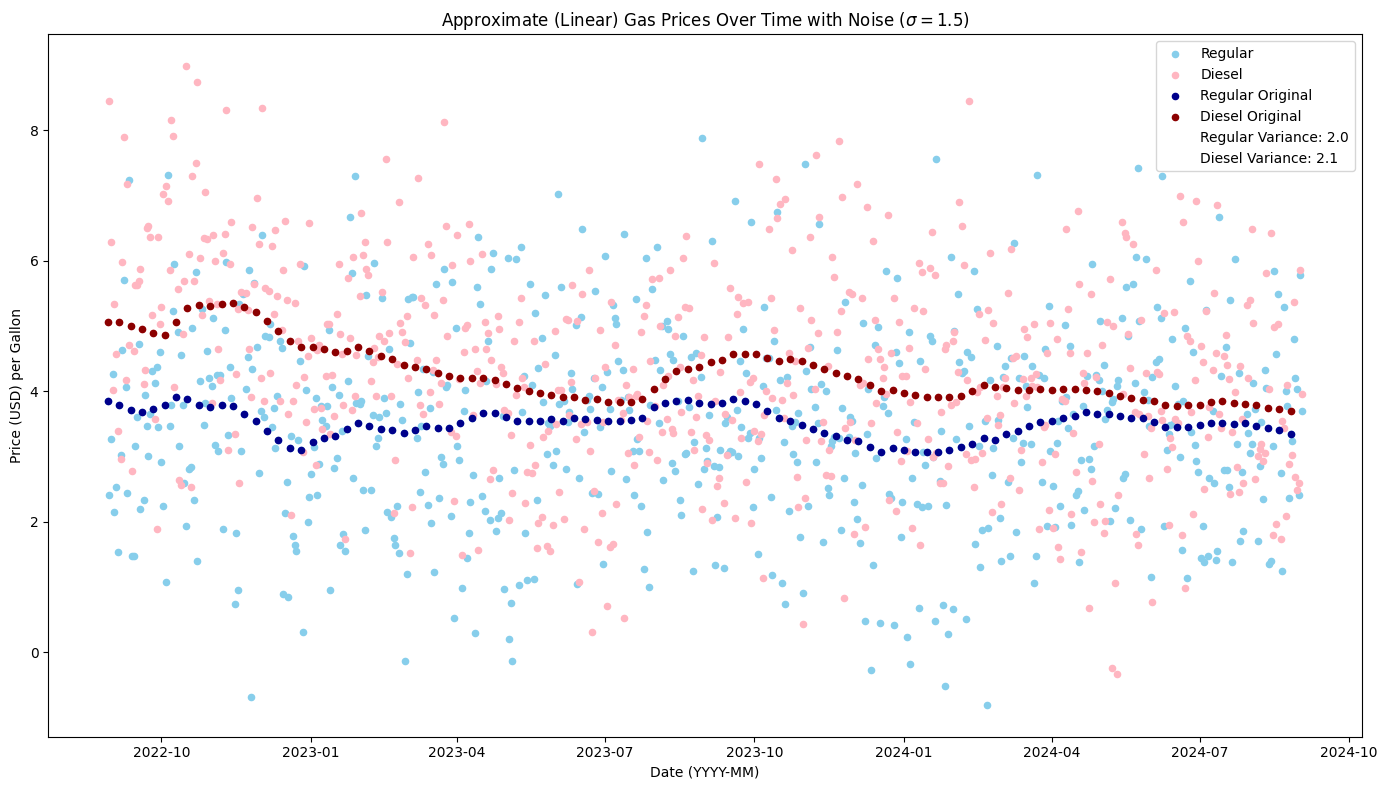

In [12]:
# Figure size
plt.figure(figsize = (14, 8))

# Plotting the approximated values
plt.scatter(GasPrices_Linear_Noisy['Date'], GasPrices_Linear_Noisy['Regular'], color='skyblue', s=20, label='Regular')
plt.scatter(GasPrices_Linear_Noisy['Date'], GasPrices_Linear_Noisy['Diesel'], color='lightpink', s=20, label='Diesel')

# Plotting the original values
plt.scatter(df['Date'], df['Regular'], color='darkblue', s=20, label='Regular Original')
plt.scatter(df['Date'], df['Diesel'], color='darkred', s=20, label='Diesel Original')

# Calculating Variance
regular_linear_noisy_var = f"Regular Variance: {round(var(GasPrices_Linear_Noisy['Regular']), 2)}"
diesel_linear_noisy_var = f"Diesel Variance: {round(var(GasPrices_Linear_Noisy['Diesel']), 2)}"

# Adding the variance to the legend
plt.plot([], [], ' ', label = regular_linear_noisy_var)
plt.plot([], [], ' ', label = diesel_linear_noisy_var)

# Labeling
plt.title('Approximate (Linear) Gas Prices Over Time with Noise ($\sigma = 1.5$)')
plt.xlabel('Date (YYYY-MM)')
plt.ylabel('Price (USD) per Gallon')
plt.legend()

# Displaying
plt.tight_layout()
plt.show()

HISTOGRAM OF THE Y-VALUES (PRICES)

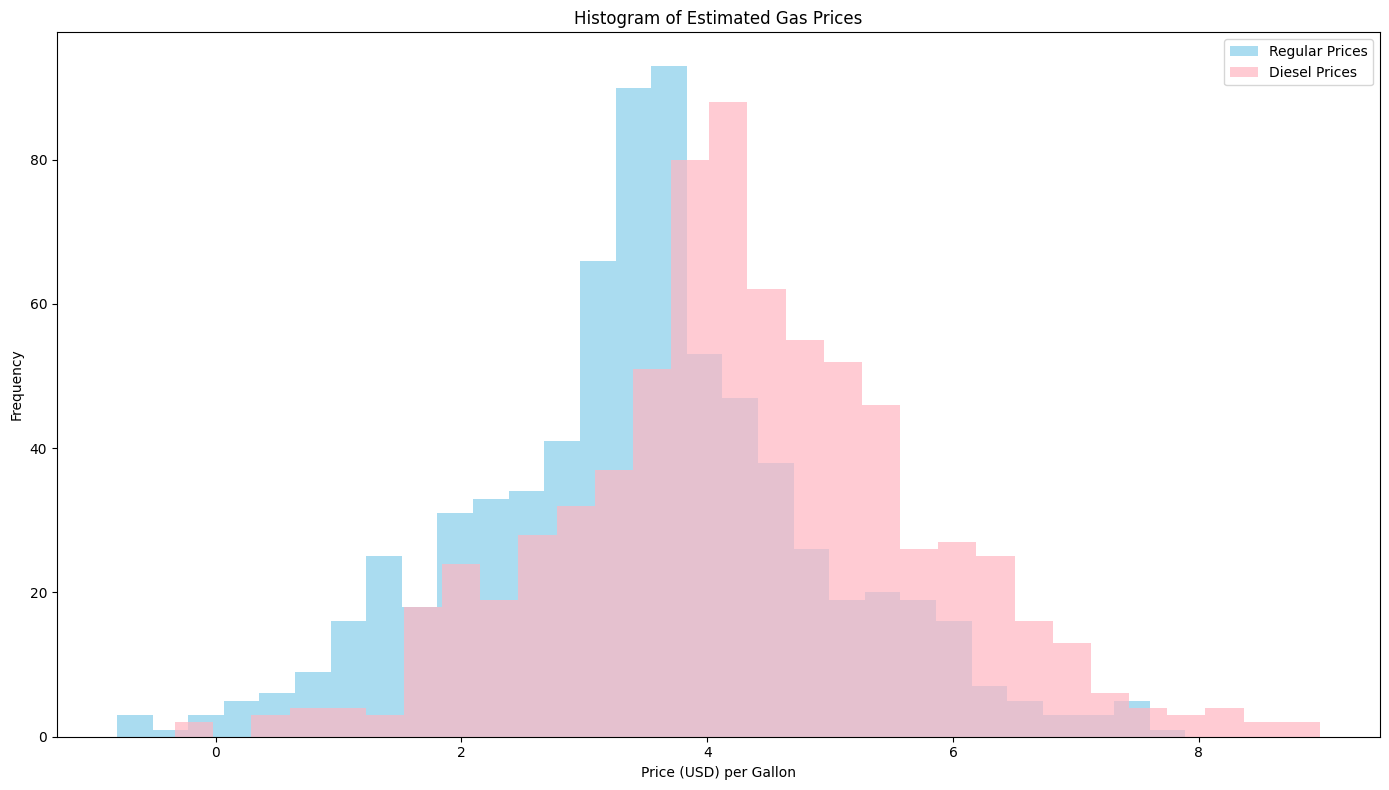

In [13]:
# Figure size
plt.figure(figsize=(14, 8))

# Plotting the histogram of approximated values
plt.hist(GasPrices_Linear_Noisy['Regular'], bins=30, color='skyblue', alpha=0.7, label='Regular Prices')
plt.hist(GasPrices_Linear_Noisy['Diesel'], bins=30, color='lightpink', alpha=0.7, label='Diesel Prices')

# Labeling
plt.title('Histogram of Estimated Gas Prices')
plt.xlabel('Price (USD) per Gallon')
plt.ylabel('Frequency')
plt.legend()

# Displaying
plt.tight_layout()
plt.show()

COMPUTED HIGH-BIAS MODEL (LINEAR REGRESSION) FOR THE IMPUTED DATA

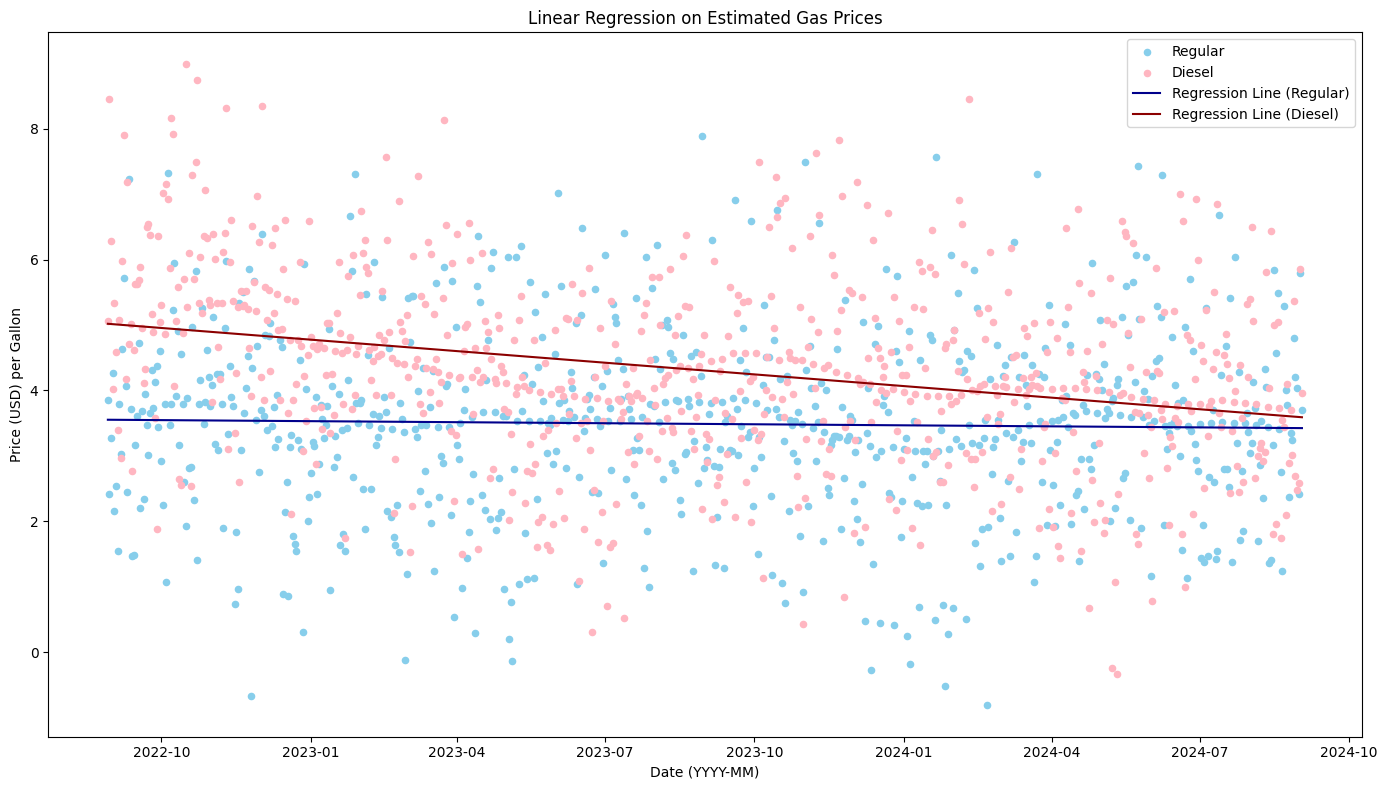

In [14]:
# Creating a sequence from 0 to the length of the DataFrame, and then turning it into a vector with reshape()
x_regular = np.arange(len(GasPrices_Linear_Noisy)).reshape(-1, 1)
y_regular = GasPrices_Linear_Noisy['Regular']
x_diesel = np.arange(len(GasPrices_Linear_Noisy)).reshape(-1, 1) 
y_diesel = GasPrices_Linear_Noisy['Diesel']

# Fitting the data in the model using the LinearRegression function
regression_regular = LinearRegression()
regression_regular.fit(x_regular, y_regular)
regression_diesel = LinearRegression()
regression_diesel.fit(x_diesel, y_diesel)

# Predicting values using the predict() function
y_predict_regular = regression_regular.predict(x_regular)
y_predict_diesel = regression_diesel.predict(x_diesel)

# Figure size
plt.figure(figsize=(14, 8))

# Plotting the approximated values
plt.scatter(GasPrices_Linear_Noisy['Date'], GasPrices_Linear_Noisy['Regular'], color='skyblue', s=20, label='Regular')
plt.scatter(GasPrices_Linear_Noisy['Date'], GasPrices_Linear_Noisy['Diesel'], color='lightpink', s=20, label='Diesel')

# Plotting the regression lines
plt.plot(GasPrices_Linear_Noisy['Date'], y_predict_regular, color='darkblue', label='Regression Line (Regular)')
plt.plot(GasPrices_Linear_Noisy['Date'], y_predict_diesel, color='darkred', label='Regression Line (Diesel)')

# Labeling
plt.title('Linear Regression on Estimated Gas Prices')
plt.xlabel('Date (YYYY-MM)')
plt.ylabel('Price (USD) per Gallon')
plt.legend()

# Displaying
plt.tight_layout()
plt.show()

#### ALTERNATIVE APPROACH: $\sigma = 0.1$

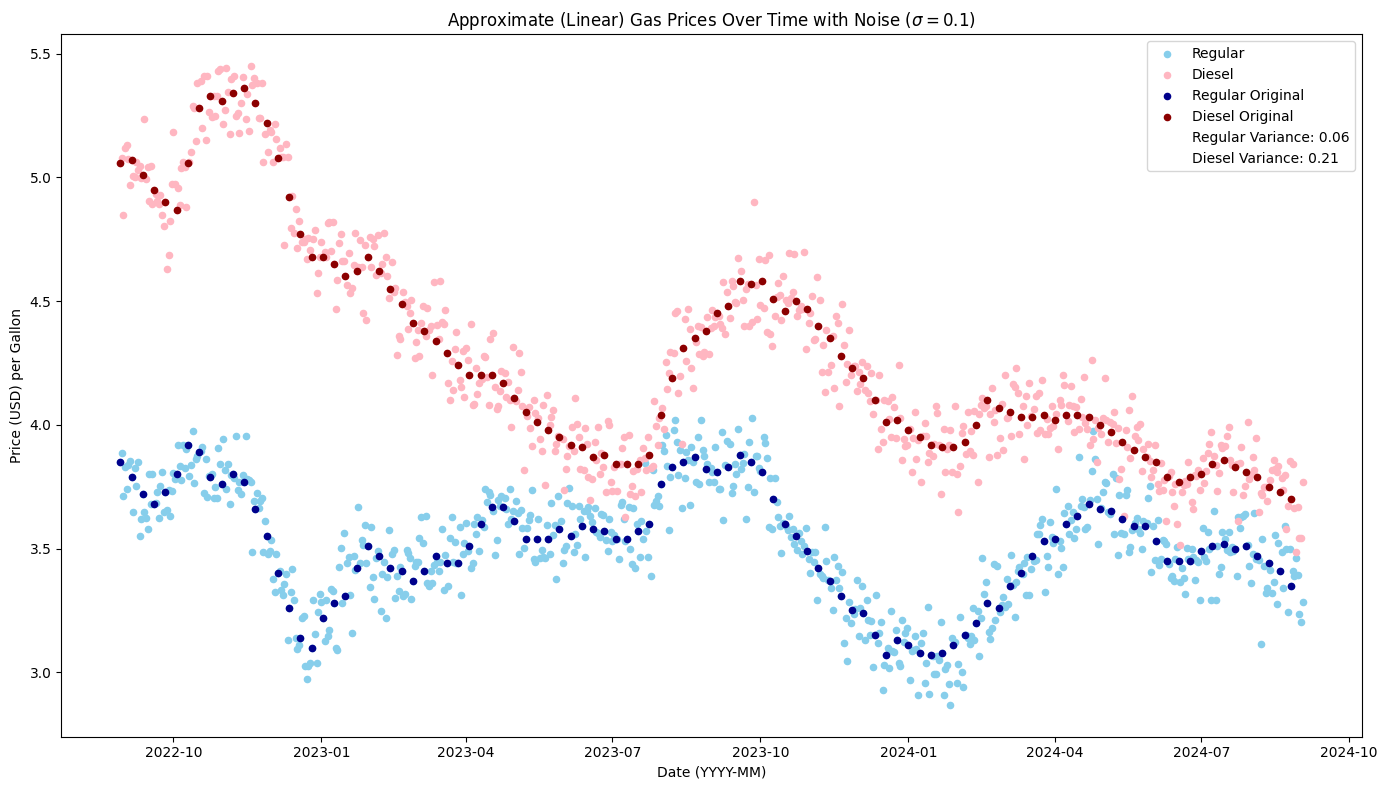

In [15]:
My_GasPrices_Linear_Noisy = df.copy()

mean = 0
standard_deviation = 0.1

My_GasPrices_Linear_Noisy['Regular'] = linearNoisyApproximate(My_GasPrices_Linear_Noisy['Regular'].values, mean, standard_deviation)
My_GasPrices_Linear_Noisy['Diesel'] = linearNoisyApproximate(My_GasPrices_Linear_Noisy['Diesel'].values, mean, standard_deviation)

plt.figure(figsize = (14, 8))

plt.scatter(My_GasPrices_Linear_Noisy['Date'], My_GasPrices_Linear_Noisy['Regular'], color='skyblue', s=20, label='Regular')
plt.scatter(My_GasPrices_Linear_Noisy['Date'], My_GasPrices_Linear_Noisy['Diesel'], color='lightpink', s=20, label='Diesel')
plt.scatter(df['Date'], df['Regular'], color='darkblue', s=20, label='Regular Original')
plt.scatter(df['Date'], df['Diesel'], color='darkred', s=20, label='Diesel Original')

regular_linear_noisy_var = f"Regular Variance: {round(var(My_GasPrices_Linear_Noisy['Regular']), 2)}"
diesel_linear_noisy_var = f"Diesel Variance: {round(var(My_GasPrices_Linear_Noisy['Diesel']), 2)}"
plt.plot([], [], ' ', label = regular_linear_noisy_var)
plt.plot([], [], ' ', label = diesel_linear_noisy_var)

plt.title('Approximate (Linear) Gas Prices Over Time with Noise ($\sigma = 0.1$)')
plt.xlabel('Date (YYYY-MM)')
plt.ylabel('Price (USD) per Gallon')
plt.legend()

plt.tight_layout()
plt.show()

HISTOGRAM OF THE Y-VALUES (PRICES)

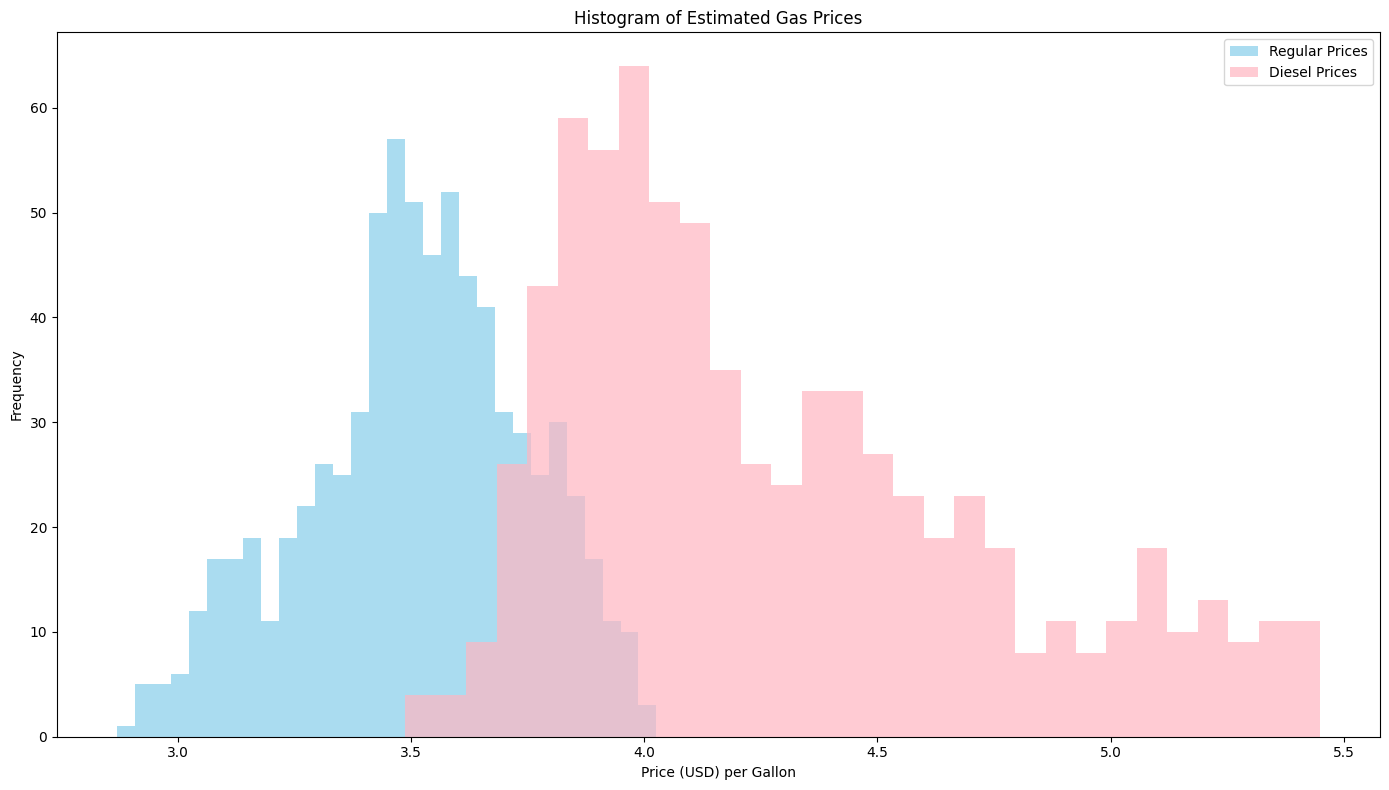

In [16]:
# Figure size
plt.figure(figsize=(14, 8))

# Plotting the histogram of approximated values
plt.hist(My_GasPrices_Linear_Noisy['Regular'], bins=30, color='skyblue', alpha=0.7, label='Regular Prices')
plt.hist(My_GasPrices_Linear_Noisy['Diesel'], bins=30, color='lightpink', alpha=0.7, label='Diesel Prices')

# Labeling
plt.title('Histogram of Estimated Gas Prices')
plt.xlabel('Price (USD) per Gallon')
plt.ylabel('Frequency')
plt.legend()

# Displaying
plt.tight_layout()
plt.show()

COMPUTED HIGH-BIAS MODEL (LINEAR REGRESSION) FOR THE IMPUTED DATA

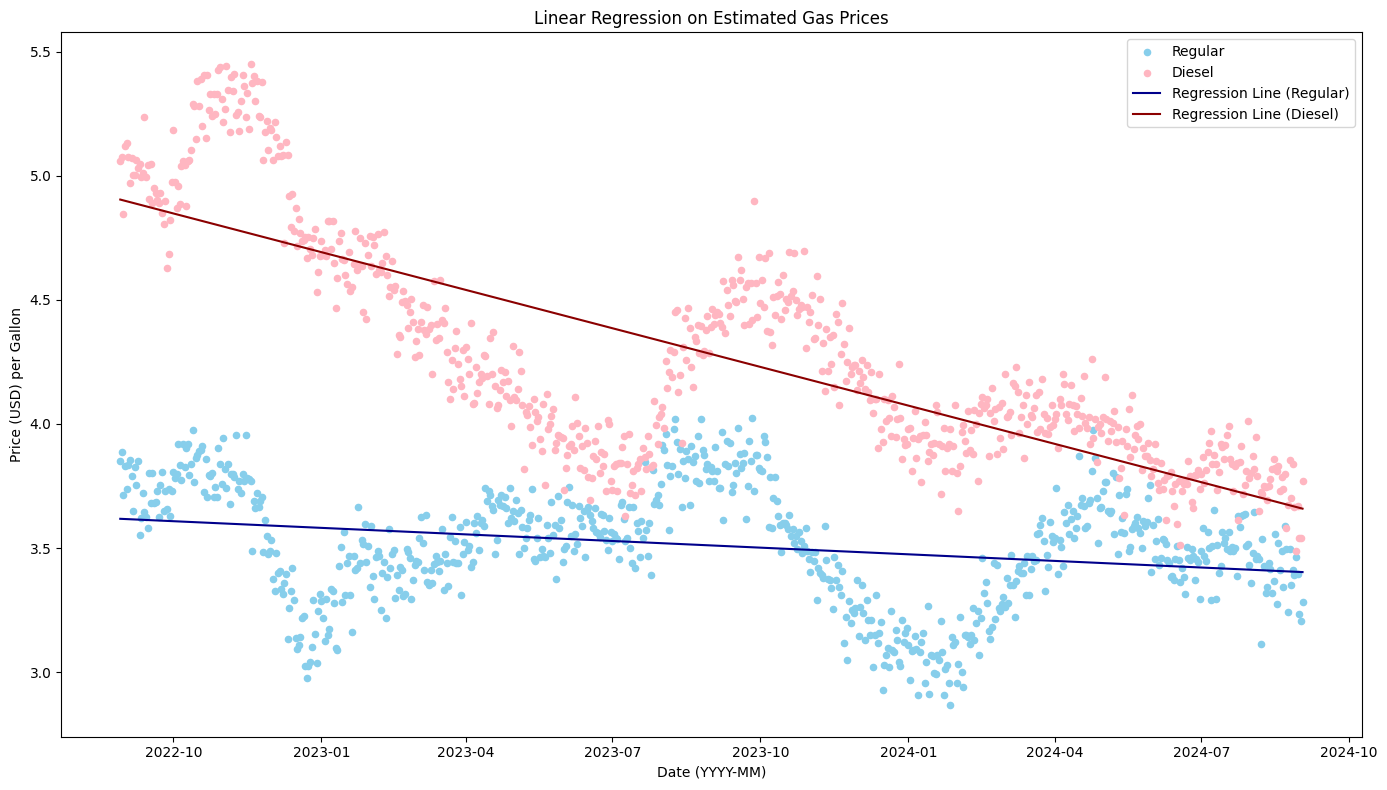

In [17]:
# Creating a sequence from 0 to the length of the DataFrame, and then turning it into a vector with reshape()
x_regular = np.arange(len(My_GasPrices_Linear_Noisy)).reshape(-1, 1)
y_regular = My_GasPrices_Linear_Noisy['Regular']
x_diesel = np.arange(len(My_GasPrices_Linear_Noisy)).reshape(-1, 1) 
y_diesel = My_GasPrices_Linear_Noisy['Diesel']

# Fitting the data in the model using the LinearRegression function
regression_regular = LinearRegression()
regression_regular.fit(x_regular, y_regular)
regression_diesel = LinearRegression()
regression_diesel.fit(x_diesel, y_diesel)

# Predicting values using the predict() function
y_predict_regular = regression_regular.predict(x_regular)
y_predict_diesel = regression_diesel.predict(x_diesel)

# Figure size
plt.figure(figsize=(14, 8))

# Plotting the approximated values
plt.scatter(My_GasPrices_Linear_Noisy['Date'], My_GasPrices_Linear_Noisy['Regular'], color='skyblue', s=20, label='Regular')
plt.scatter(My_GasPrices_Linear_Noisy['Date'], My_GasPrices_Linear_Noisy['Diesel'], color='lightpink', s=20, label='Diesel')

# Plotting the regression lines
plt.plot(My_GasPrices_Linear_Noisy['Date'], y_predict_regular, color='darkblue', label='Regression Line (Regular)')
plt.plot(My_GasPrices_Linear_Noisy['Date'], y_predict_diesel, color='darkred', label='Regression Line (Diesel)')

# Labeling
plt.title('Linear Regression on Estimated Gas Prices')
plt.xlabel('Date (YYYY-MM)')
plt.ylabel('Price (USD) per Gallon')
plt.legend()

# Displaying
plt.tight_layout()
plt.show()

## QUADRATIC APPROXIMATION

My approach for quadratic approximation is the same as linear, however with a few extra conditions to deal with three points. In linear approximation we had two different cases, the entire dataset, and the extra week into the future. For quadratic approximation, we have three cases: 

1- The extra week into the future. Where we have to use the values from the last three weeks to estimate the values. In this case I assign $x_1$, $x_2$, and $x_3$ in a way to ensure that the first slope (first derivative) is closest to the point being estimated. It has to be mentioned, that this is not a really good approximation, but its the best we can do with the data we have.

2- The last week of our dataset. Here we only have one next point, rather than two. So we use the two previous points and the first next point to estimate the values. Instead of setting the $x$ values in order however, I'll set them in a way that the next point is the center point, rather than the previous point, to ensure more accurate approximation.

3- The rest of the dataset. This is the base case, where we have a previous case (as always), and two next points. I'll set the $x$ values in a way that the center point is the previous point, to ensure the best approximation.

After assigning my $x$ and $y$ values, I'll calculates the two slopes, considering the first slope as the first derivative. To get the second derivative I calculate delta $x$, and then get the second derivative using delta $x$, and the two slopes. Finally, I'll plug the values into the quadratic taylor series to get the estimated value. Here, $y$ is the the NaN value, being replaced (estimated).

Finally, after the estimations are done, we'll proceed with calling the functions, and visualizing the data.


In [18]:
# Defining a function to quadratically approximate the missing values and return a numpy array
def quadraticApproximate(column: np.ndarray) -> np.ndarray:
    weekly_prices = column.copy() # Storing the column's original values
    length = len(column) # Length of the column we are estimating

    # Looping through the column
    for i in range(1, length):
        # Stopping at NaN values, to estimate them
        if pd.isna(column[i]):
            # Marking previous index (which is never NaN)
            prevIndex = i - 1

            # Looking for the first next non-NaN value
            nextIndex = i + 1
            while nextIndex < length and pd.isna(weekly_prices[nextIndex]):
                nextIndex += 1

            # Looking for the second next non-NaN value
            farNextIndex = nextIndex + 1
            while farNextIndex < length and pd.isna(weekly_prices[farNextIndex]):
                farNextIndex += 1

            # Looking for the second previous non-NaN value
            farPrevIndex = prevIndex - 1
            while pd.isna(weekly_prices[farPrevIndex]):
                farPrevIndex -= 1

            # Looking for the third previous non-NaN value
            farFarPrevIndex = farPrevIndex - 1
            while pd.isna(weekly_prices[farFarPrevIndex]):
                farFarPrevIndex -= 1

            # In the case of the extra week in the future, there is no next point(s) to use, so we use the last three points
            # this case happens when nextIndex is greater than or equal to the length (out of our data range) which will also mean farNextIndex is out of range
            if nextIndex >= length:
                # Setting the coordinates of the known original points
                y1, y2, y3 = weekly_prices[prevIndex], weekly_prices[farPrevIndex], weekly_prices[farFarPrevIndex]
                x1, x2, x3 = prevIndex, farPrevIndex, farFarPrevIndex
            
            # In the case of the last week recorded (not the week into future), we use the last two points and the next point (as we don't have a second next point)
            # this case happens when farNextIndex is greater than or equal to the length (out of our data range) but the first next point exists
            elif farNextIndex >= length and nextIndex < length:
                # Setting the coordinates of the known original points
                y1, y2, y3 = weekly_prices[prevIndex], weekly_prices[nextIndex], weekly_prices[farPrevIndex]
                x1, x2, x3 = prevIndex, nextIndex, farPrevIndex
            
            # In the case of the other weeks, we use the previous point, the next point, and the second next point
            # this case happens when farNextIndex is within our data range
            elif farNextIndex < length:
                # Setting the coordinates of the known original points
                y1, y2, y3 = weekly_prices[nextIndex], weekly_prices[prevIndex], weekly_prices[farNextIndex]
                x1, x2, x3 = nextIndex, prevIndex, farNextIndex
            else:
                # This will never be reached, but its here for safety
                raise ValueError("Invalid State")

            # Calculating the slopes
            slope1 = (y2 - y1) / (x2 - x1)
            slope2 = (y3 - y2) / (x3 - x2)

            # Calculating derivatives
            delta_x = (x3 - x1) / 2 # Average distance between two points 

            f_prime = slope1  # first derivative
            f_double_prime = (slope2 - slope1) / delta_x # second derivative

            # Filling in the missing values in the week
            for j in range(prevIndex + 1, nextIndex):
                if pd.isna(column[j]): 
                    # Using the quadratic taylor series to estimate the missing value
                    column[j] = y1 + f_prime * (j - x1) + 0.5 * f_double_prime * (j - x1) ** 2
                    ## print(f"index {j} estimated with {x1}, {x2}, {x3} and values {y1}, {y2}, {y3}") # For debugging

    # Returning the updated column
    return column

In [19]:
# Making a copy of the original dataframe to avoid modifying it
GasPrices_Quadratic = df.copy()
# Estimating the missing values in the Regular and Diesel columns one by one
GasPrices_Quadratic['Regular'] = quadraticApproximate(GasPrices_Quadratic['Regular'].values)
GasPrices_Quadratic['Diesel'] = quadraticApproximate(GasPrices_Quadratic['Diesel'].values)
# Saving the updated dataframe to a CSV file
GasPrices_Quadratic.to_csv("GasPrices_Quadratic.csv")

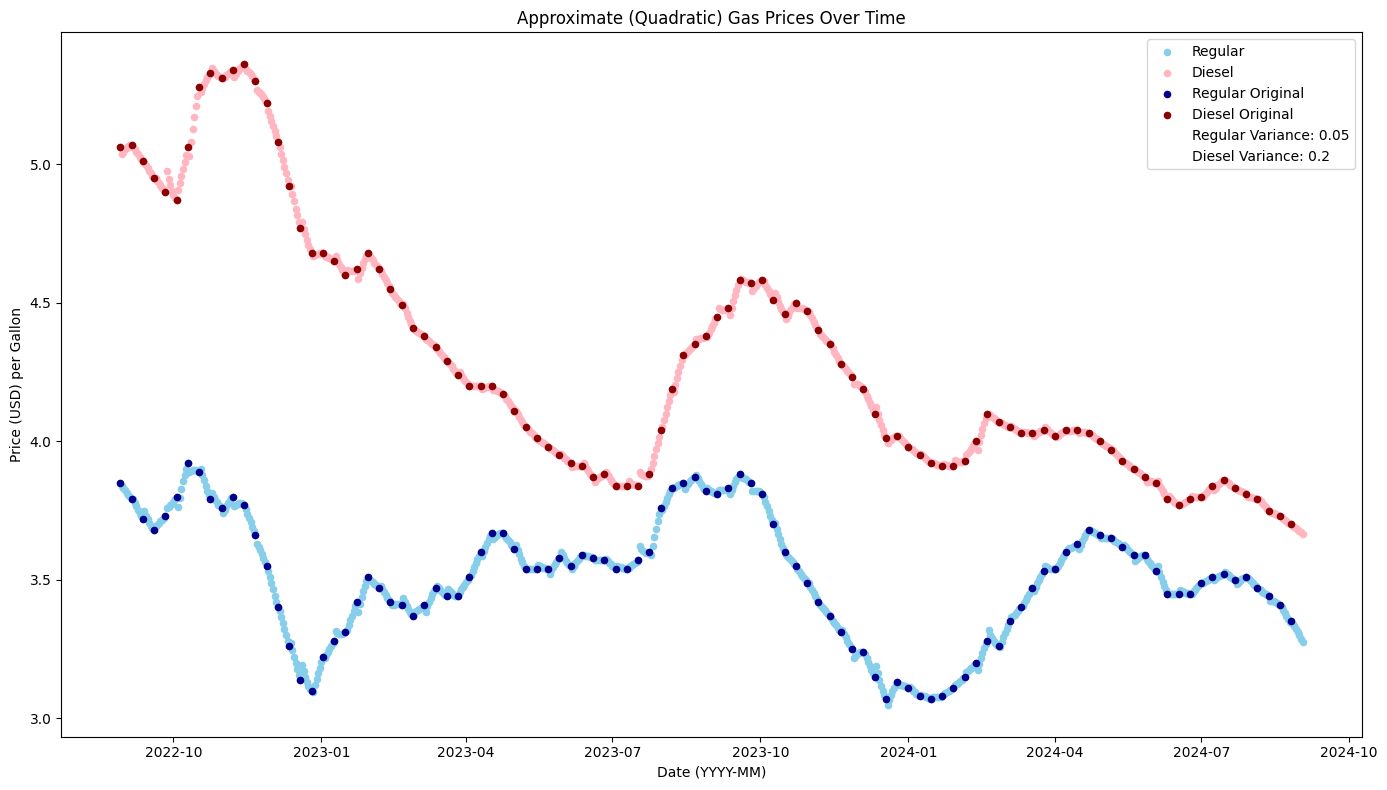

In [20]:
# Figure size
plt.figure(figsize = (14, 8))

# Plotting the approximated values
plt.scatter(GasPrices_Quadratic['Date'], GasPrices_Quadratic['Regular'], color='skyblue', s=20, label='Regular')
plt.scatter(GasPrices_Quadratic['Date'], GasPrices_Quadratic['Diesel'], color='lightpink', s=20, label='Diesel')

# Plotting the original values
plt.scatter(df['Date'], df['Regular'], color='darkblue', s=20, label='Regular Original')
plt.scatter(df['Date'], df['Diesel'], color='darkred', s=20, label='Diesel Original')

# Calculating Variance
regular_quad_var = f"Regular Variance: {round(var(GasPrices_Quadratic['Regular']), 2)}"
diesel_quad_var = f"Diesel Variance: {round(var(GasPrices_Quadratic['Diesel']), 2)}"

# Adding the variance to the legend
plt.plot([], [], ' ', label = regular_quad_var)
plt.plot([], [], ' ', label = diesel_quad_var)

# Labeling
plt.title('Approximate (Quadratic) Gas Prices Over Time')
plt.xlabel('Date (YYYY-MM)')
plt.ylabel('Price (USD) per Gallon')
plt.legend()

# Displaying
plt.tight_layout()
plt.show()

HISTROGRAM OF THE Y-VALUES (PRICES)

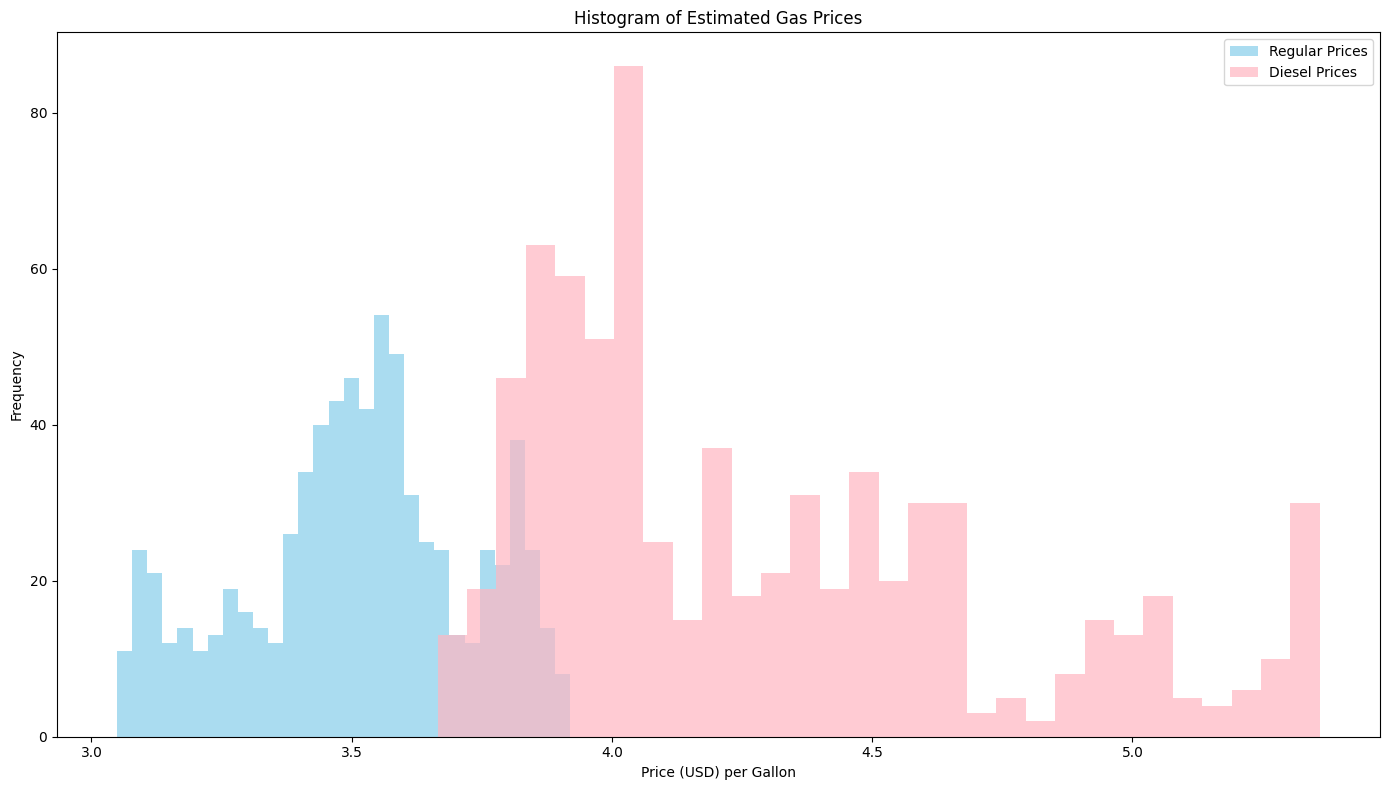

In [21]:
# Figure size
plt.figure(figsize=(14, 8))

# Plotting the histogram of approximated values
plt.hist(GasPrices_Quadratic['Regular'], bins=30, color='skyblue', alpha=0.7, label='Regular Prices')
plt.hist(GasPrices_Quadratic['Diesel'], bins=30, color='lightpink', alpha=0.7, label='Diesel Prices')

# Labeling
plt.title('Histogram of Estimated Gas Prices')
plt.xlabel('Price (USD) per Gallon')
plt.ylabel('Frequency')
plt.legend()

# Displaying
plt.tight_layout()
plt.show()

COMPUTED HIGH-BIAS MODEL (LINEAR REGRESSION) FOR THE IMPUTED DATA

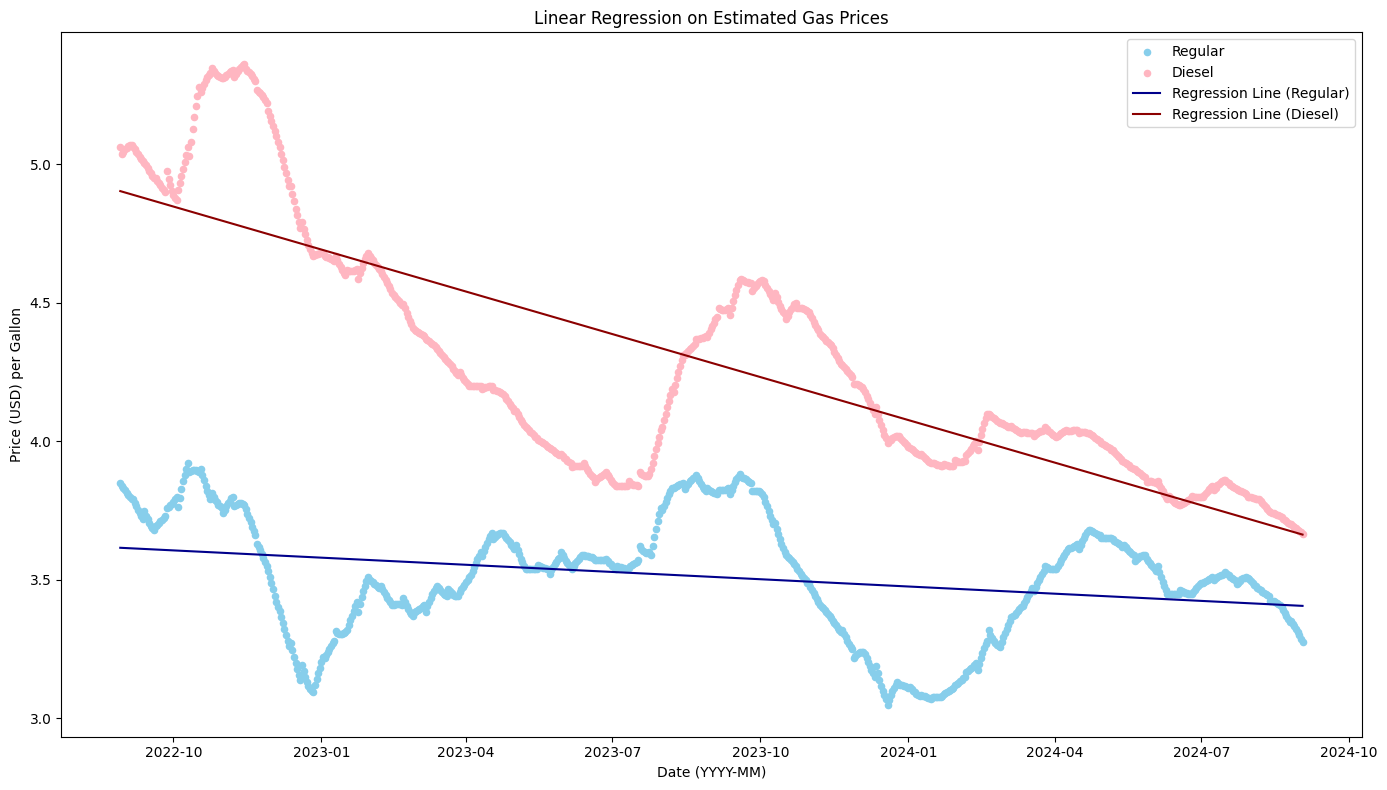

In [22]:
# Creating a sequence from 0 to the length of the DataFrame, and then turning it into a vector with reshape()
x_regular = np.arange(len(GasPrices_Quadratic)).reshape(-1, 1)
y_regular = GasPrices_Quadratic['Regular']
x_diesel = np.arange(len(GasPrices_Quadratic)).reshape(-1, 1) 
y_diesel = GasPrices_Quadratic['Diesel']

# Fitting the data in the model using the LinearRegression function
regression_regular = LinearRegression()
regression_regular.fit(x_regular, y_regular)
regression_diesel = LinearRegression()
regression_diesel.fit(x_diesel, y_diesel)

# Predicting values using the predict() function
y_predict_regular = regression_regular.predict(x_regular)
y_predict_diesel = regression_diesel.predict(x_diesel)

# Figure size
plt.figure(figsize=(14, 8))

# Plotting the approximated values
plt.scatter(GasPrices_Quadratic['Date'], GasPrices_Quadratic['Regular'], color='skyblue', s=20, label='Regular')
plt.scatter(GasPrices_Quadratic['Date'], GasPrices_Quadratic['Diesel'], color='lightpink', s=20, label='Diesel')

# Plotting the regression lines
plt.plot(GasPrices_Quadratic['Date'], y_predict_regular, color='darkblue', label='Regression Line (Regular)')
plt.plot(GasPrices_Quadratic['Date'], y_predict_diesel, color='darkred', label='Regression Line (Diesel)')

# Labeling
plt.title('Linear Regression on Estimated Gas Prices')
plt.xlabel('Date (YYYY-MM)')
plt.ylabel('Price (USD) per Gallon')
plt.legend()

# Displaying
plt.tight_layout()
plt.show()

## QUADRATIC APPROXIMATION WITH NOISE

Just like adding noise to the linearly approximated values, I'll add noise to the quadratic approximated values with $\sigma = 1.5$, while again, also showing the alternative approach with $\sigma = 0.1$.

In [23]:
# Defining a function to quadratically approximate the missing values and return a numpy array
# It also takes in the mean and standard deviation of the noise to add to the estimated values
def quadraticNoisyApproximate(column: np.ndarray, mean, std) -> np.ndarray:
    weekly_prices = column.copy() # Storing the column's original values
    length = len(column) # Length of the column we are estimating

    # Making a noise array to add to the estimated values
    noise = np.random.normal(mean, std, size = column.shape)

    # Looping through the column
    for i in range(1, length):
        # Stopping at NaN values, to estimate them
        if pd.isna(column[i]):
            # Marking previous index (which is never NaN)
            prevIndex = i - 1

            # Looking for the first next non-NaN value
            nextIndex = i + 1
            while nextIndex < length and pd.isna(weekly_prices[nextIndex]):
                nextIndex += 1

            # Looking for the second next non-NaN value
            farNextIndex = nextIndex + 1
            while farNextIndex < length and pd.isna(weekly_prices[farNextIndex]):
                farNextIndex += 1

            # Looking for the second previous non-NaN value
            farPrevIndex = prevIndex - 1
            while pd.isna(weekly_prices[farPrevIndex]):
                farPrevIndex -= 1

            # Looking for the third previous non-NaN value
            farFarPrevIndex = farPrevIndex - 1
            while pd.isna(weekly_prices[farFarPrevIndex]):
                farFarPrevIndex -= 1

            # In the case of the extra week in the future, there is no next point(s) to use, so we use the last three points
            # this case happens when nextIndex is greater than or equal to the length (out of our data range) which will also mean farNextIndex is out of range
            if nextIndex >= length:
                # Setting the coordinates of the known original points
                y1, y2, y3 = weekly_prices[prevIndex], weekly_prices[farPrevIndex], weekly_prices[farFarPrevIndex]
                x1, x2, x3 = prevIndex, farPrevIndex, farFarPrevIndex
            
            # In the case of the last week recorded (not the week into future), we use the last two points and the next point (as we don't have a second next point)
            # this case happens when farNextIndex is greater than or equal to the length (out of our data range) but the first next point exists
            elif farNextIndex >= length and nextIndex < length:
                # Setting the coordinates of the known original points
                y1, y2, y3 = weekly_prices[prevIndex], weekly_prices[nextIndex], weekly_prices[farPrevIndex]
                x1, x2, x3 = prevIndex, nextIndex, farPrevIndex
            
            # In the case of the other weeks, we use the previous point, the next point, and the second next point
            # this case happens when farNextIndex is within our data range
            elif farNextIndex < length:
                # Setting the coordinates of the known original points
                y1, y2, y3 = weekly_prices[nextIndex], weekly_prices[prevIndex], weekly_prices[farNextIndex]
                x1, x2, x3 = nextIndex, prevIndex, farNextIndex
            else:
                # This will never be reached, but its here for safety
                raise ValueError("Invalid State")

            # Calculating the slopes
            slope1 = (y2 - y1) / (x2 - x1)
            slope2 = (y3 - y2) / (x3 - x2)

            # Calculating derivatives
            delta_x = (x3 - x1) / 2 # Average distance between two points 

            f_prime = slope1  # first derivative
            f_double_prime = (slope2 - slope1) / delta_x # second derivative

            # Filling in the missing values in the week
            for j in range(prevIndex + 1, nextIndex):
                if pd.isna(column[j]): 
                    # Using the quadratic taylor series to estimate the missing value
                    column[j] = (y1 + f_prime * (j - x1) + 0.5 * f_double_prime * (j - x1) ** 2) + noise[j] # Adding noise to each estimated value

    # Returning the updated column
    return column

In [24]:
# Making a copy of the original dataframe to avoid modifying it
GasPrices_Quadratic_Noisy = df.copy()
# Declaring the mean and standard deviation of the noise
mean = 0
standard_deviation = 1.5
# Estimating the missing values in the Regular and Diesel columns one by one
GasPrices_Quadratic_Noisy['Regular'] = quadraticNoisyApproximate(GasPrices_Quadratic_Noisy['Regular'].values, mean, standard_deviation)
GasPrices_Quadratic_Noisy['Diesel'] = quadraticNoisyApproximate(GasPrices_Quadratic_Noisy['Diesel'].values, mean, standard_deviation)
# Saving the updated dataframe to a CSV file
GasPrices_Quadratic_Noisy.to_csv("GasPrices_Quadratic_Noisy.csv")

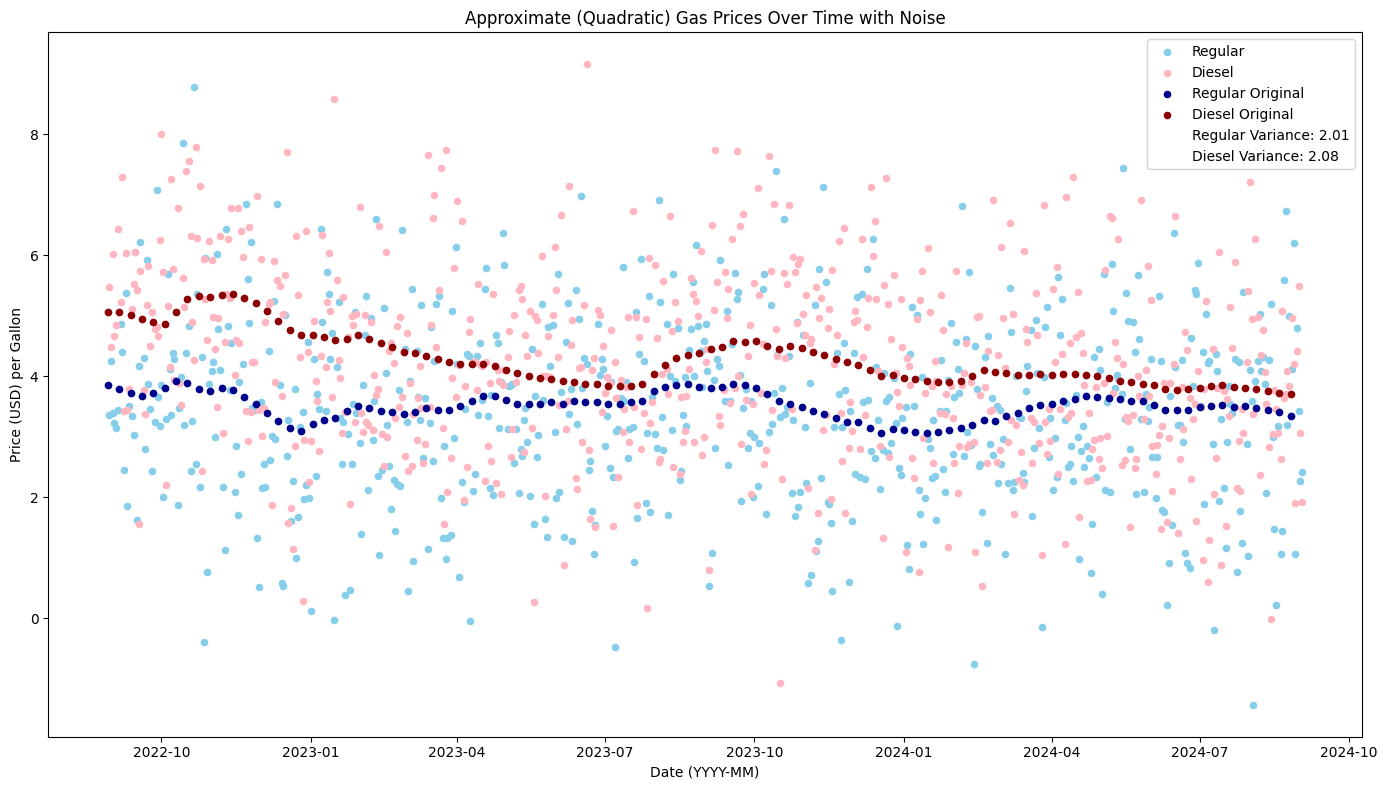

In [25]:
# Figure size
plt.figure(figsize = (14, 8))

# Plotting the approximated values
plt.scatter(GasPrices_Quadratic_Noisy['Date'], GasPrices_Quadratic_Noisy['Regular'], color='skyblue', s=20, label='Regular')
plt.scatter(GasPrices_Quadratic_Noisy['Date'], GasPrices_Quadratic_Noisy['Diesel'], color='lightpink', s=20, label='Diesel')

# Plotting the original values
plt.scatter(df['Date'], df['Regular'], color='darkblue', s=20, label='Regular Original')
plt.scatter(df['Date'], df['Diesel'], color='darkred', s=20, label='Diesel Original')

# Calculating Variance
regular_quad_noisy_var = f"Regular Variance: {round(var(GasPrices_Quadratic_Noisy['Regular']), 2)}"
diesel_quad_noisy_var = f"Diesel Variance: {round(var(GasPrices_Quadratic_Noisy['Diesel']), 2)}"

# Adding the variance to the legend
plt.plot([], [], ' ', label = regular_quad_noisy_var)
plt.plot([], [], ' ', label = diesel_quad_noisy_var)

# Labeling
plt.title('Approximate (Quadratic) Gas Prices Over Time with Noise')
plt.xlabel('Date (YYYY-MM)')
plt.ylabel('Price (USD) per Gallon')
plt.legend()

# Displaying
plt.tight_layout()
plt.show()

HISTROGRAM OF THE Y-VALUES (PRICES)

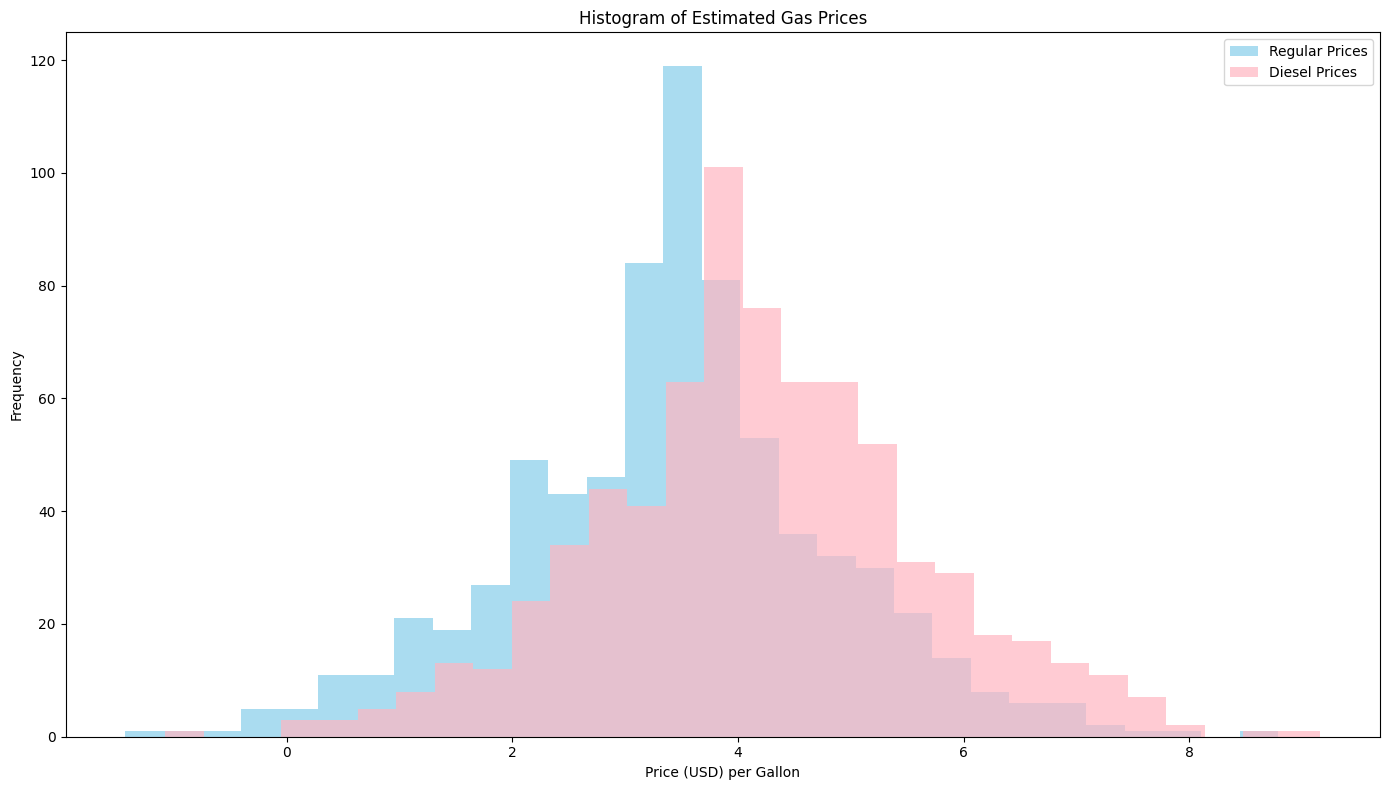

In [26]:
# Figure size
plt.figure(figsize=(14, 8))

# Plotting the histogram of approximated values
plt.hist(GasPrices_Quadratic_Noisy['Regular'], bins=30, color='skyblue', alpha=0.7, label='Regular Prices')
plt.hist(GasPrices_Quadratic_Noisy['Diesel'], bins=30, color='lightpink', alpha=0.7, label='Diesel Prices')

# Labeling
plt.title('Histogram of Estimated Gas Prices')
plt.xlabel('Price (USD) per Gallon')
plt.ylabel('Frequency')
plt.legend()

# Displaying
plt.tight_layout()
plt.show()

COMPUTED HIGH-BIAS MODEL (LINEAR REGRESSION) FOR THE IMPUTED DATA

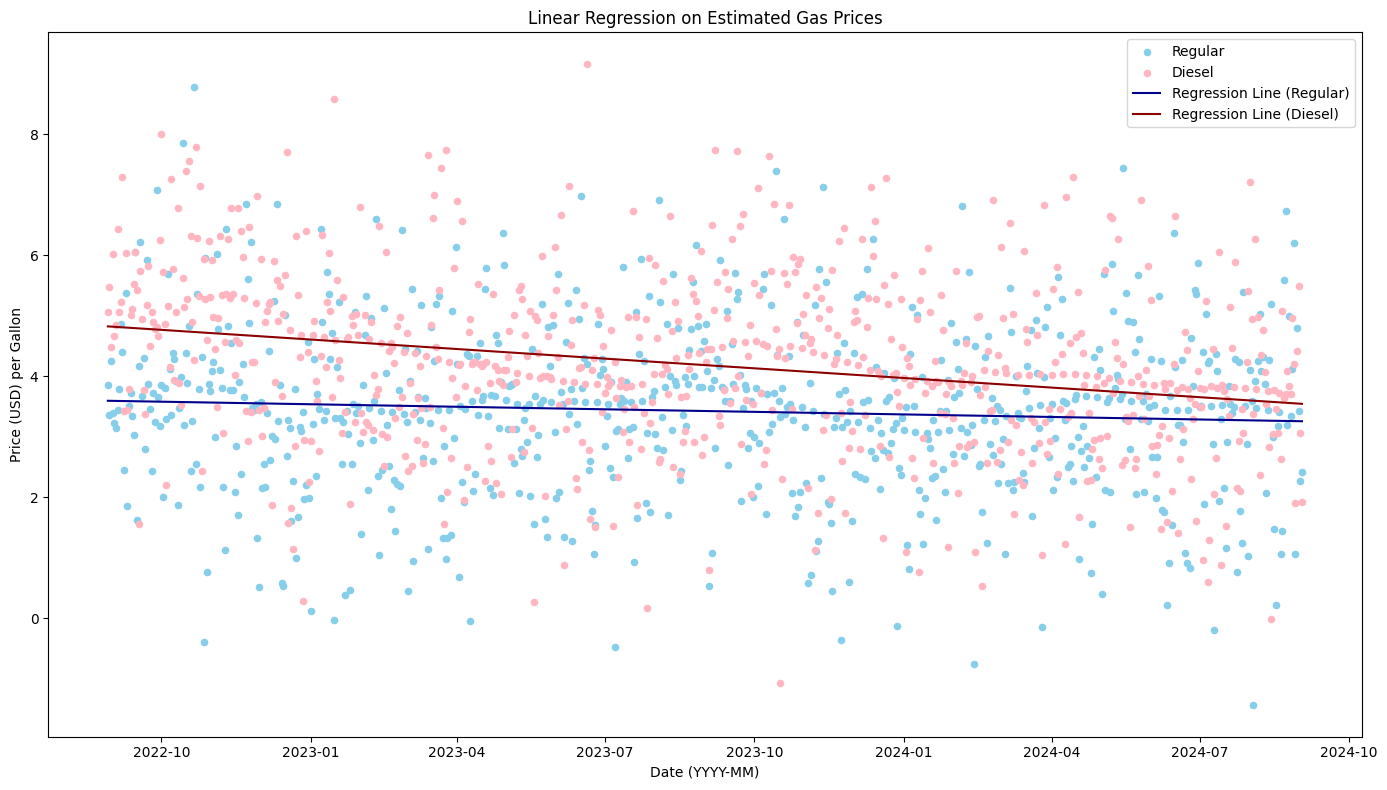

In [27]:
# Creating a sequence from 0 to the length of the DataFrame, and then turning it into a vector with reshape()
x_regular = np.arange(len(GasPrices_Quadratic_Noisy)).reshape(-1, 1)
y_regular = GasPrices_Quadratic_Noisy['Regular']
x_diesel = np.arange(len(GasPrices_Quadratic_Noisy)).reshape(-1, 1) 
y_diesel = GasPrices_Quadratic_Noisy['Diesel']

# Fitting the data in the model using the LinearRegression function
regression_regular = LinearRegression()
regression_regular.fit(x_regular, y_regular)
regression_diesel = LinearRegression()
regression_diesel.fit(x_diesel, y_diesel)

# Predicting values using the predict() function
y_predict_regular = regression_regular.predict(x_regular)
y_predict_diesel = regression_diesel.predict(x_diesel)

# Figure size
plt.figure(figsize=(14, 8))

# Plotting the approximated values
plt.scatter(GasPrices_Quadratic_Noisy['Date'], GasPrices_Quadratic_Noisy['Regular'], color='skyblue', s=20, label='Regular')
plt.scatter(GasPrices_Quadratic_Noisy['Date'], GasPrices_Quadratic_Noisy['Diesel'], color='lightpink', s=20, label='Diesel')

# Plotting the regression lines
plt.plot(GasPrices_Quadratic_Noisy['Date'], y_predict_regular, color='darkblue', label='Regression Line (Regular)')
plt.plot(GasPrices_Quadratic_Noisy['Date'], y_predict_diesel, color='darkred', label='Regression Line (Diesel)')

# Labeling
plt.title('Linear Regression on Estimated Gas Prices')
plt.xlabel('Date (YYYY-MM)')
plt.ylabel('Price (USD) per Gallon')
plt.legend()

# Displaying
plt.tight_layout()
plt.show()

#### Alternative approach – $\sigma = 0.1$

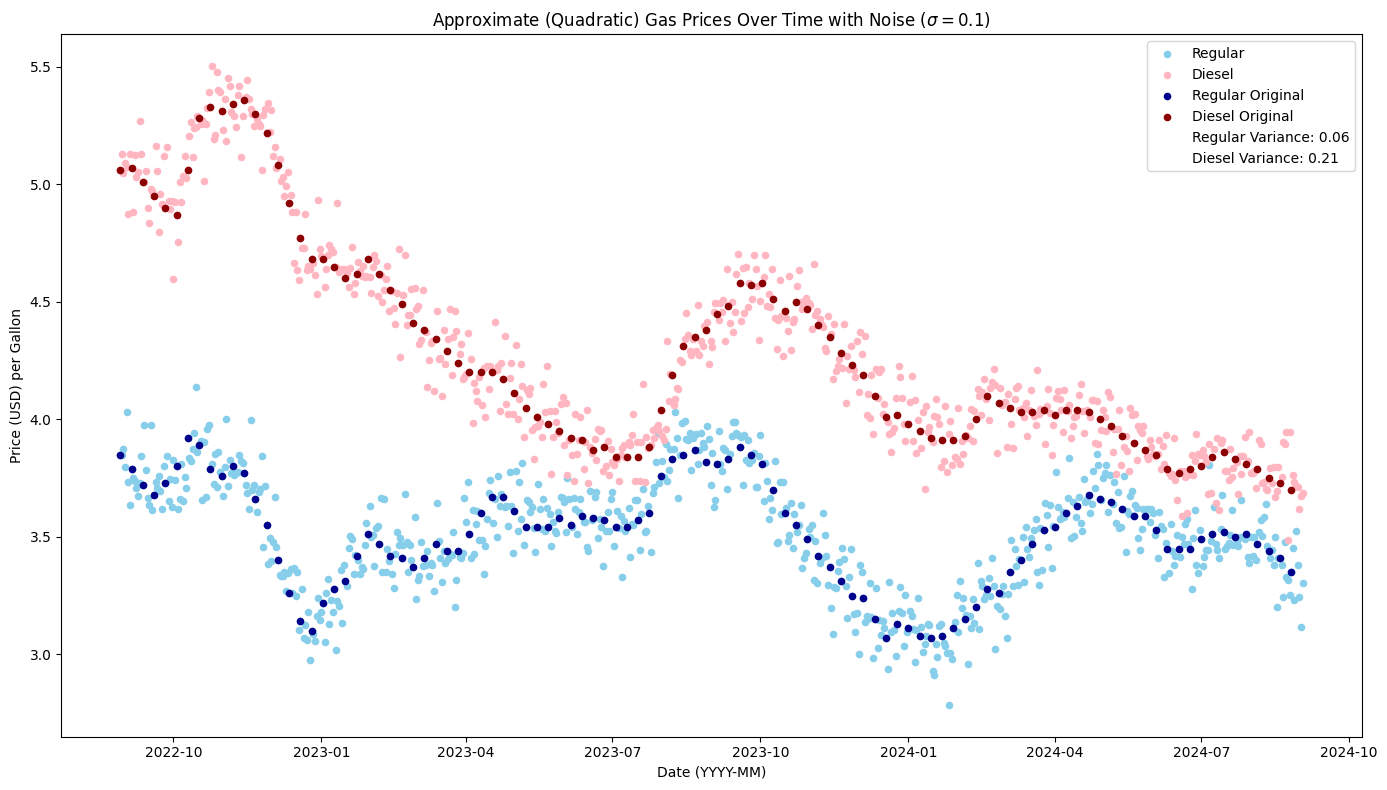

In [28]:
My_GasPrices_Quadratic_Noisy = df.copy()

mean = 0
standard_deviation = 0.1

My_GasPrices_Quadratic_Noisy['Regular'] = quadraticNoisyApproximate(My_GasPrices_Quadratic_Noisy['Regular'].values, mean, standard_deviation)
My_GasPrices_Quadratic_Noisy['Diesel'] = quadraticNoisyApproximate(My_GasPrices_Quadratic_Noisy['Diesel'].values, mean, standard_deviation)

plt.figure(figsize = (14, 8))

plt.scatter(My_GasPrices_Quadratic_Noisy['Date'], My_GasPrices_Quadratic_Noisy['Regular'], color='skyblue', s=20, label='Regular')
plt.scatter(My_GasPrices_Quadratic_Noisy['Date'], My_GasPrices_Quadratic_Noisy['Diesel'], color='lightpink', s=20, label='Diesel')
plt.scatter(df['Date'], df['Regular'], color='darkblue', s=20, label='Regular Original')
plt.scatter(df['Date'], df['Diesel'], color='darkred', s=20, label='Diesel Original')

regular_quad_noisy_var = f"Regular Variance: {round(var(My_GasPrices_Quadratic_Noisy['Regular']), 2)}"
diesel_quad_noisy_var = f"Diesel Variance: {round(var(My_GasPrices_Quadratic_Noisy['Diesel']), 2)}"
plt.plot([], [], ' ', label = regular_quad_noisy_var)
plt.plot([], [], ' ', label = diesel_quad_noisy_var)

plt.title('Approximate (Quadratic) Gas Prices Over Time with Noise ($\sigma = 0.1$)')
plt.xlabel('Date (YYYY-MM)')
plt.ylabel('Price (USD) per Gallon')
plt.legend()

plt.tight_layout()
plt.show()

HISTROGRAM OF THE Y-VALUES (PRICES)

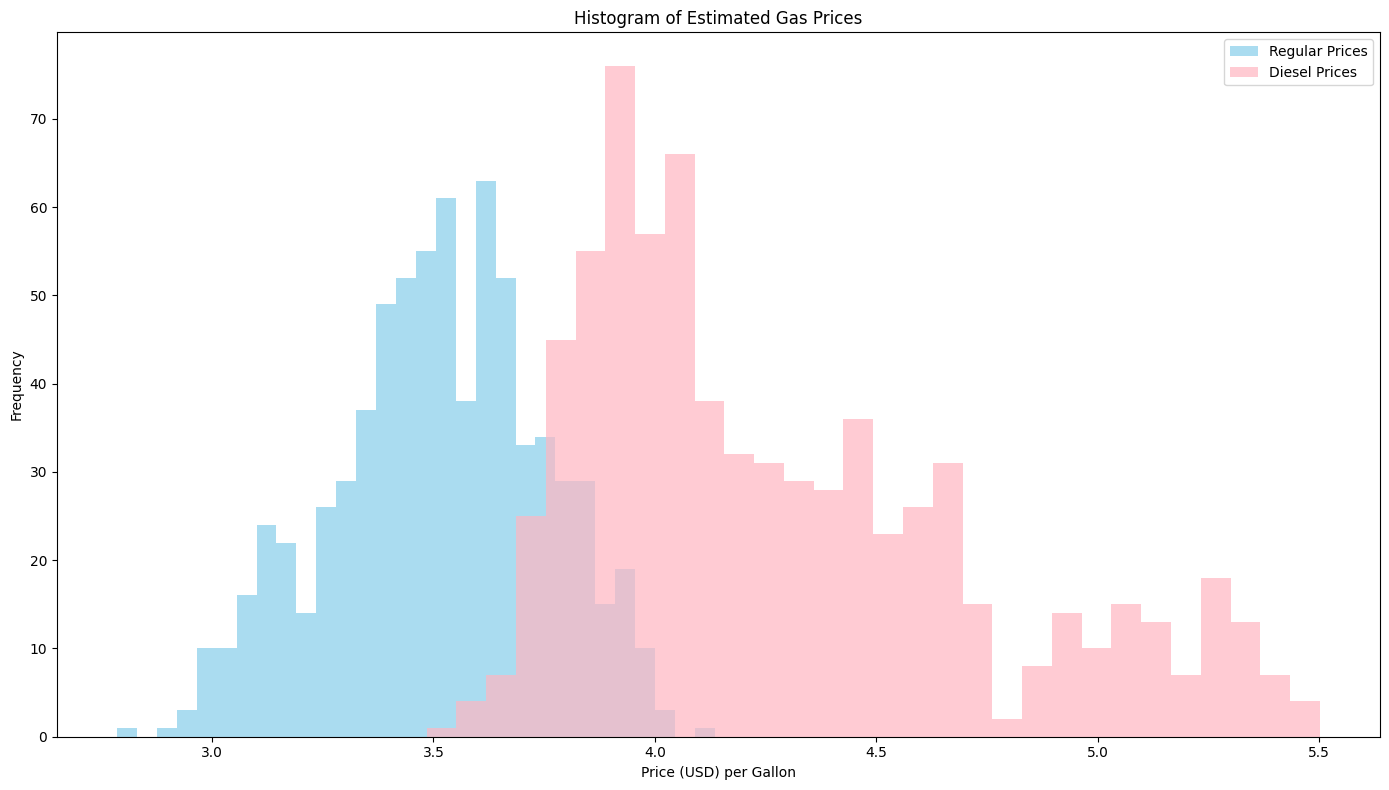

In [29]:
# Figure size
plt.figure(figsize=(14, 8))

# Plotting the histogram of approximated values
plt.hist(My_GasPrices_Quadratic_Noisy['Regular'], bins=30, color='skyblue', alpha=0.7, label='Regular Prices')
plt.hist(My_GasPrices_Quadratic_Noisy['Diesel'], bins=30, color='lightpink', alpha=0.7, label='Diesel Prices')

# Labeling
plt.title('Histogram of Estimated Gas Prices')
plt.xlabel('Price (USD) per Gallon')
plt.ylabel('Frequency')
plt.legend()

# Displaying
plt.tight_layout()
plt.show()

COMPUTED HIGH-BIAS MODEL (LINEAR REGRESSION) FOR THE IMPUTED DATA

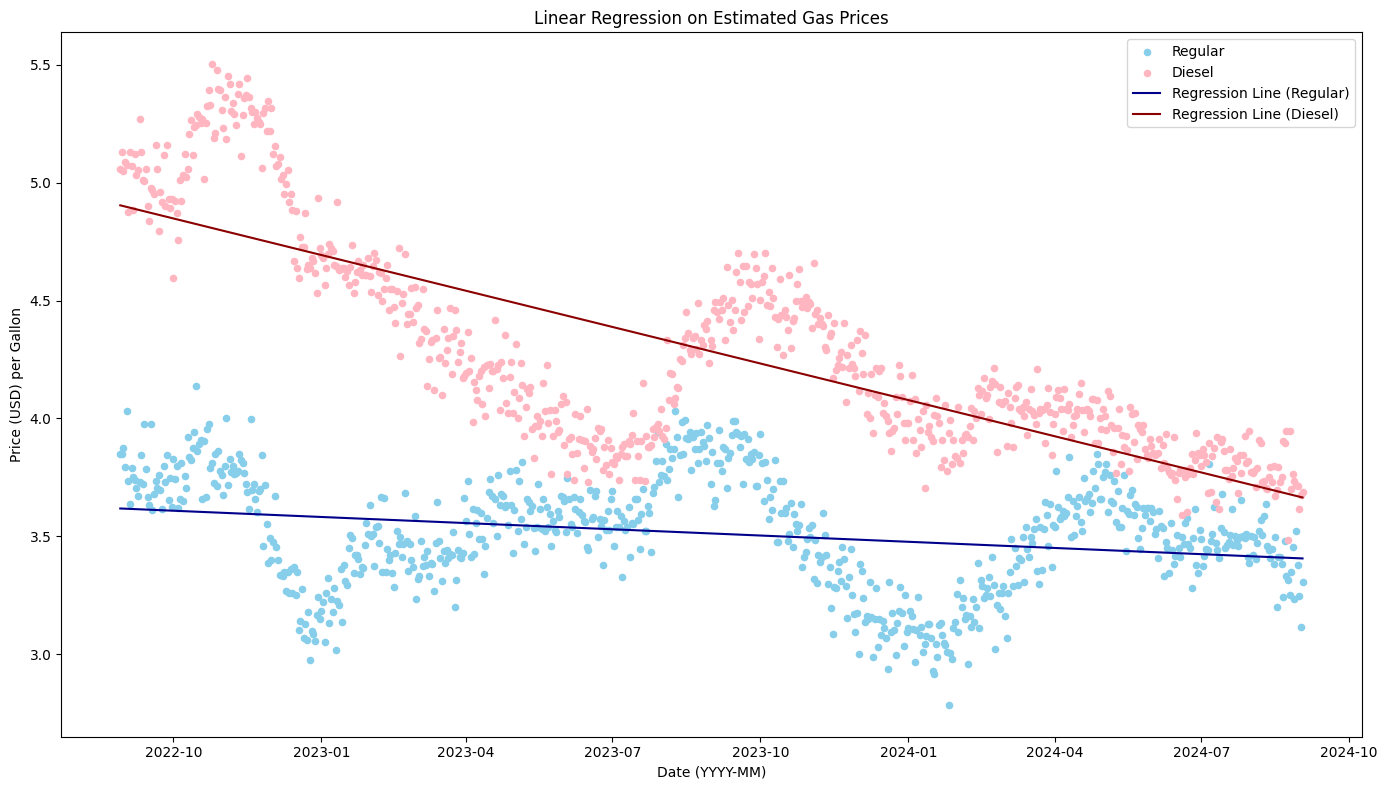

In [30]:
# Creating a sequence from 0 to the length of the DataFrame, and then turning it into a vector with reshape()
x_regular = np.arange(len(My_GasPrices_Quadratic_Noisy)).reshape(-1, 1)
y_regular = My_GasPrices_Quadratic_Noisy['Regular']
x_diesel = np.arange(len(My_GasPrices_Quadratic_Noisy)).reshape(-1, 1) 
y_diesel = My_GasPrices_Quadratic_Noisy['Diesel']

# Fitting the data in the model using the LinearRegression function
regression_regular = LinearRegression()
regression_regular.fit(x_regular, y_regular)
regression_diesel = LinearRegression()
regression_diesel.fit(x_diesel, y_diesel)

# Predicting values using the predict() function
y_predict_regular = regression_regular.predict(x_regular)
y_predict_diesel = regression_diesel.predict(x_diesel)

# Figure size
plt.figure(figsize=(14, 8))

# Plotting the approximated values
plt.scatter(My_GasPrices_Quadratic_Noisy['Date'], My_GasPrices_Quadratic_Noisy['Regular'], color='skyblue', s=20, label='Regular')
plt.scatter(My_GasPrices_Quadratic_Noisy['Date'], My_GasPrices_Quadratic_Noisy['Diesel'], color='lightpink', s=20, label='Diesel')

# Plotting the regression lines
plt.plot(My_GasPrices_Quadratic_Noisy['Date'], y_predict_regular, color='darkblue', label='Regression Line (Regular)')
plt.plot(My_GasPrices_Quadratic_Noisy['Date'], y_predict_diesel, color='darkred', label='Regression Line (Diesel)')

# Labeling
plt.title('Linear Regression on Estimated Gas Prices')
plt.xlabel('Date (YYYY-MM)')
plt.ylabel('Price (USD) per Gallon')
plt.legend()

# Displaying
plt.tight_layout()
plt.show()

## HOT DECK APPROXIMATION

For hot deck imputation, I'll first make a copy of the original DataFrame, and then remove the NaN values from the column and set it to another numpy array. Then I'll iterate through the column, and if the value is NaN, I'll replace it with a random value from the numpy array. When the loop is done iterating, I'll return the column.

In [31]:
# Defining a function to approximate the missing values with hot deck approach and return a numpy array
def hotDeckApproximate(column: np.ndarray) -> np.ndarray:
    weekly_prices = column.copy() # Storing the column's original values

    # Removing NaN values from the column to get an array of only the original prices
    original_prices = weekly_prices[~pd.isna(weekly_prices)]
    
    # Looping through the column
    for i in range(1, len(column)):
        # Stopping at NaN values, to estimate them
        if pd.isna(column[i]):
            # Choosing a random value from the array of original prices and filling the NaN values
            column[i] = np.random.choice(original_prices)
    
    # Returning the updated column
    return column

In [32]:
# Making a copy of the original dataframe to avoid modifying it
GasPrices_HotDeck = df.copy()
# Estimating the missing values in the Regular and Diesel columns one by one
GasPrices_HotDeck['Regular'] = hotDeckApproximate(GasPrices_HotDeck['Regular'].values)
GasPrices_HotDeck['Diesel'] = hotDeckApproximate(GasPrices_HotDeck['Diesel'].values)
# Saving the updated dataframe to a CSV file
GasPrices_HotDeck.to_csv("GasPrices_HotDeck.csv")

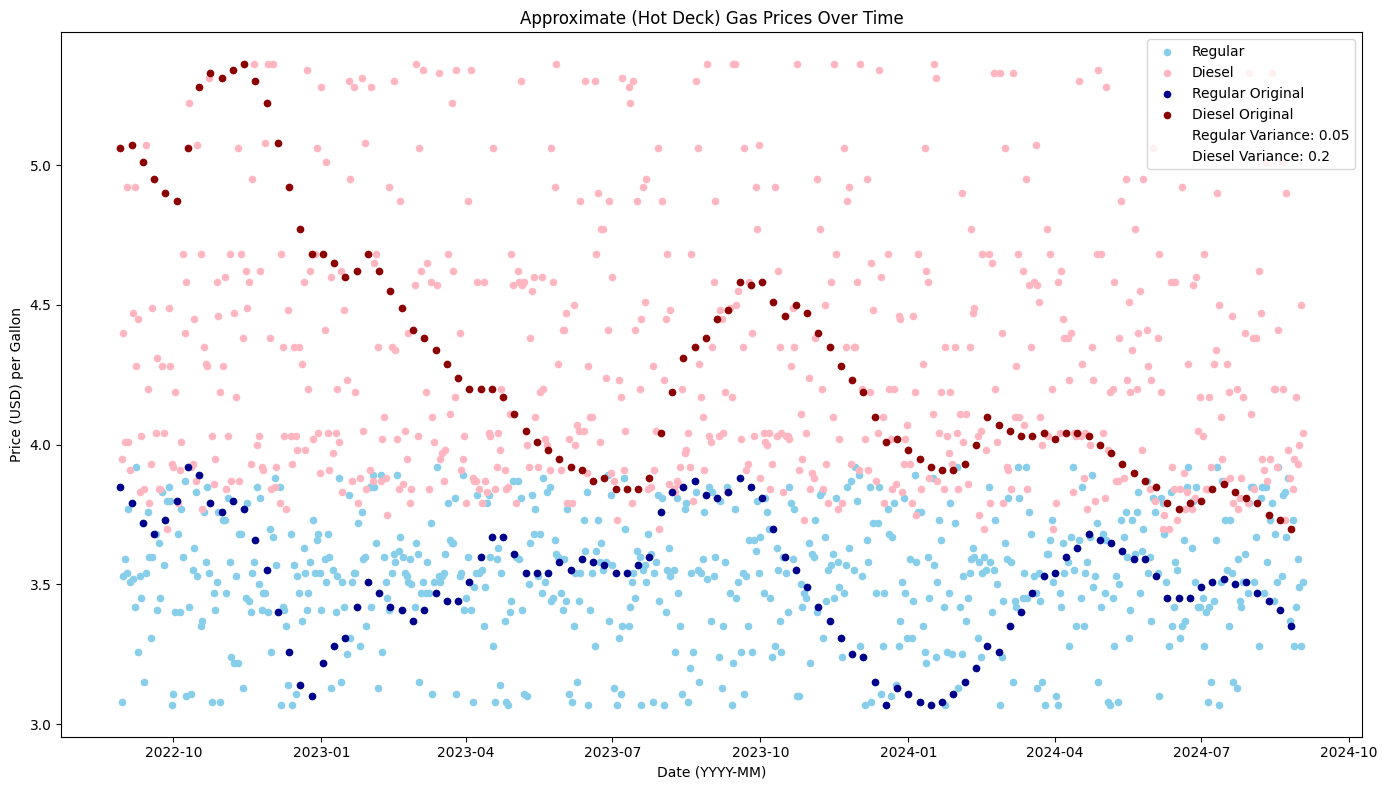

In [33]:
# Figure size
plt.figure(figsize = (14, 8))

# Plotting the approximated values
plt.scatter(GasPrices_HotDeck['Date'], GasPrices_HotDeck['Regular'], color='skyblue', s=20, label='Regular')
plt.scatter(GasPrices_HotDeck['Date'], GasPrices_HotDeck['Diesel'], color='lightpink', s=20, label='Diesel')

# Plotting the original values
plt.scatter(df['Date'], df['Regular'], color='darkblue', s=20, label='Regular Original')
plt.scatter(df['Date'], df['Diesel'], color='darkred', s=20, label='Diesel Original')

# Calculating Variance
regular_hot_deck_var = f"Regular Variance: {round(var(GasPrices_HotDeck['Regular']), 2)}"
diesel_hot_deck_var = f"Diesel Variance: {round(var(GasPrices_HotDeck['Diesel']), 2)}"

# Adding the variance to the legend
plt.plot([], [], ' ', label = regular_hot_deck_var)
plt.plot([], [], ' ', label = diesel_hot_deck_var)

# Labeling
plt.title('Approximate (Hot Deck) Gas Prices Over Time')
plt.xlabel('Date (YYYY-MM)')
plt.ylabel('Price (USD) per Gallon')
plt.legend()

# Displaying
plt.tight_layout()
plt.show()

HISTROGRAM OF THE Y-VALUES (PRICES)

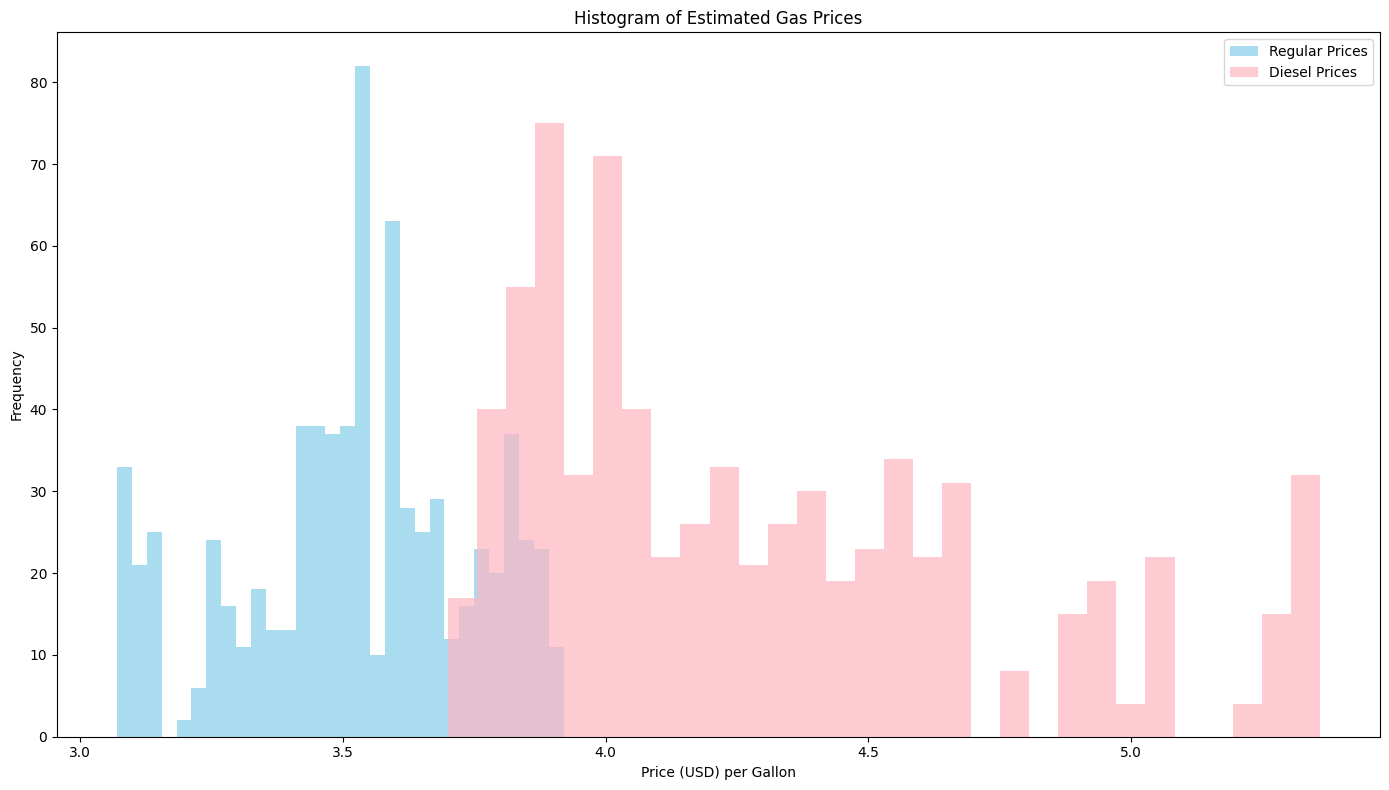

In [34]:
# Figure size
plt.figure(figsize=(14, 8))

# Plotting the histogram of approximated values
plt.hist(GasPrices_HotDeck['Regular'], bins=30, color='skyblue', alpha=0.7, label='Regular Prices')
plt.hist(GasPrices_HotDeck['Diesel'], bins=30, color='lightpink', alpha=0.7, label='Diesel Prices')

# Labeling
plt.title('Histogram of Estimated Gas Prices')
plt.xlabel('Price (USD) per Gallon')
plt.ylabel('Frequency')
plt.legend()

# Displaying
plt.tight_layout()
plt.show()

COMPUTED HIGH-BIAS MODEL (LINEAR REGRESSION) FOR THE IMPUTED DATA

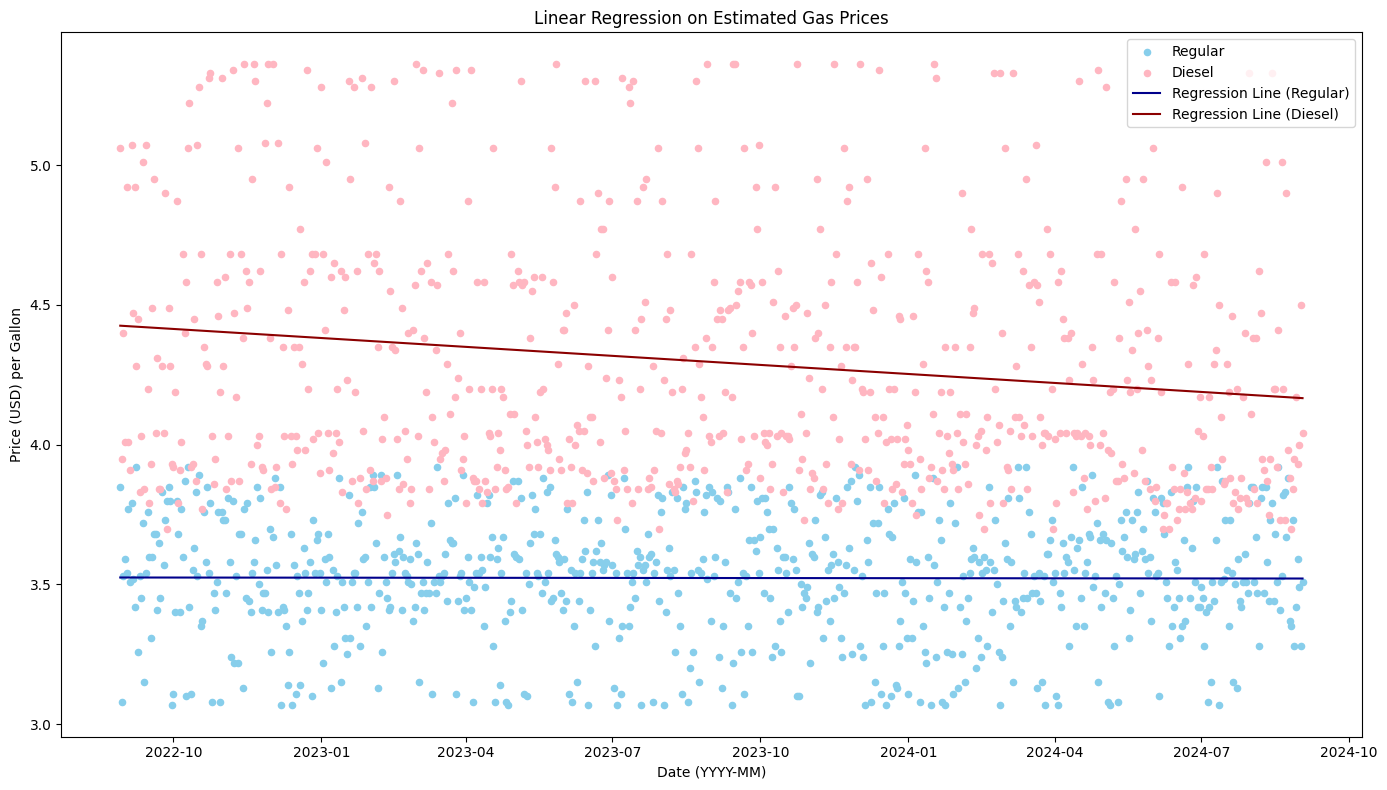

In [35]:
# Creating a sequence from 0 to the length of the DataFrame, and then turning it into a vector with reshape()
x_regular = np.arange(len(GasPrices_HotDeck)).reshape(-1, 1)
y_regular = GasPrices_HotDeck['Regular']
x_diesel = np.arange(len(GasPrices_HotDeck)).reshape(-1, 1) 
y_diesel = GasPrices_HotDeck['Diesel']

# Fitting the data in the model using the LinearRegression function
regression_regular = LinearRegression()
regression_regular.fit(x_regular, y_regular)
regression_diesel = LinearRegression()
regression_diesel.fit(x_diesel, y_diesel)

# Predicting values using the predict() function
y_predict_regular = regression_regular.predict(x_regular)
y_predict_diesel = regression_diesel.predict(x_diesel)

# Figure size
plt.figure(figsize=(14, 8))

# Plotting the approximated values
plt.scatter(GasPrices_HotDeck['Date'], GasPrices_HotDeck['Regular'], color='skyblue', s=20, label='Regular')
plt.scatter(GasPrices_HotDeck['Date'], GasPrices_HotDeck['Diesel'], color='lightpink', s=20, label='Diesel')

# Plotting the regression lines
plt.plot(GasPrices_HotDeck['Date'], y_predict_regular, color='darkblue', label='Regression Line (Regular)')
plt.plot(GasPrices_HotDeck['Date'], y_predict_diesel, color='darkred', label='Regression Line (Diesel)')

# Labeling
plt.title('Linear Regression on Estimated Gas Prices')
plt.xlabel('Date (YYYY-MM)')
plt.ylabel('Price (USD) per Gallon')
plt.legend()

# Displaying
plt.tight_layout()
plt.show()

# **WRITE-UP SUMMARY**

Quadratic approximation is the most effective method for filling in missing data, as it uses three points for estimation, unlike linear approximation which uses only two. However, when projecting future values, linear approximation performs better. This is evident when comparing the scatterplots for the final week, where the quadratic approximation skews the estimated points, while the linear approximation continues smoothly based on the two closest points.

Hot deck approximation, while useful for categorical data with repeatable patterns, like surveys, is unsuitable for gas prices. Since gas prices follow a time-dependent trend, randomly selecting past prices does not provide an accurate estimate.

Gas prices generally follow a somewhat linear trend, though they are not perfectly linear. Adding noise can make the estimations more realistic, but as shown in the histograms, prices tend to cluster around specific points, with variances of 0.05 and 0.2, so a standard deviation of 1.5 is too large, as we can see, the scatterplots of that noise don't produce a good approximation of the missing data. Using a standard deviation of 0.1, as shown in the alternative approach in each case, produces a much better and realistic approximation of the missing data.

Finally, the linear regression line offers a useful high-bias model, highlighting the overall trend rather than focusing on individual data points. In this project, it reveals a gradual decrease in regular gas prices and a sharper decline in diesel prices over time, allowing us to draw meaningful conclusions about the long-term trends in gas prices.